## Separating 1D maps

In [1]:
import random as rnd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

In [2]:
#function implementing the algorithm outlined above
def find_curves(X,eps = 0.05,eps_grad = 0.1, separation = 0.05):
    '''
    X the lag 1 2D time embedding sorted on x coords
    eps
    eps_grad
    separation the separation bound for recursion algorithm
    '''
    #start at point with max separation between two points
    start = np.argmax(np.abs(X[:-1,1]-X[1:,1]))
    n = len(X)

    #variable to store assigned points
    A1 = [X[start,:]]
    #variable to store unassigned points
    A2 = []
    #store numerical derivative of assigned points
    A1dot = []
    
    #walk right from start point assigning points based on criteria
    for i in range(start+1,n-1):
        if len(A1dot)>0:
            #calculate numerical derivative
            diff = (A1[-1][1]-X[i,1])/(2*(A1[-1][0]-X[i,0]))
            #check if continuous with continuous derivative
            if np.linalg.norm(A1[-1]-X[i,:]) < eps and abs(A1dot[-1] - diff)< eps_grad:
                A1.append(X[i,:])
                A1dot.append(diff)
            else: #else leave points unassigned
                A2.append(X[i,:])
        else:
            #no derivative information so set a tighter bound on eps
            if np.linalg.norm(A1[-1]-X[i,:]) < eps/2:
                diff = (A1[-1][1]-X[i,1])/(2*(A1[-1][0]-X[i,0]))
                A1.append(X[i,:])
                A1dot.append(diff)
            else:
                A2.append(X[i,:])

    #flip order to now walk left from start point
    A1 = A1[::-1]
    A1dot = A1dot[::-1]
    A2 = A2[::-1]

    # walk left from start point assign points based on criteria
    for i in range(1,start):
        if len(A1dot)>0:
            #calculate numerical derivative
            diff = (A1[-1][1]-X[start-i,1])/(2*(A1[-1][0]-X[start-i,0]))       
            if np.linalg.norm(A1[-1]-X[start-i,:]) < eps and abs(A1dot[-1] - diff)< eps_grad:
                A1dot.append(diff)
                A1.append(X[start-i,:])

            else: #else leave point unassigned
                A2.append(X[start-i,:])

        #no derivative information so set a tighter bound on eps
        else:
            if np.linalg.norm(A1[-1]-X[start-i,:]) < eps/2:
                A1.append(X[start-i,:])

                A1dot.append((A1[1][1]-A1[0][1])/(2*(A1[1][0]-A1[0][0])))
            else:
                A2.append(X[start-i,:])

    #Flip A1 and A2 back so that x coordinates are sorted from min to max again.
    A1 = A1[::-1]
    A2 = A2[::-1]
    #convert list into arrays
    A1 = np.stack(A1)
    
    #check to see if more than one continuous curve present in A2
    #First check A2 is not empty e.g. when only one curve or when a single point remained unclassified
    if len(A2)>1:
        A2 = np.stack(A2)
        #check is separation bound is met
        a = max(np.sqrt((A2[:-1,1]-A2[1:,1])**2 + (A2[:-1,0]-A2[1:,0])**2))
        if a <separation:
            return [A1,A2]
    
        else:
        #if not repeat algorithm on unassigned points
            return [A1] + find_curves(A2)
    
    #If A2 is empty 
    else:
        return [A1]
    

def find_piecewise_curves(X,eps = 0.05,eps_grad = 0.1, sep = 0.05):
    '''
    glue piecewise curves together
    X the lag 1 2D time embedding
    eps
    eps_grad
    sep the separation bound for recursion algorithm
    '''
    #find continuous curve segments
    curves = find_curves(X,eps,eps_grad, sep)
    
    #break for loop variable
    stop = 1
    while stop == 1:
        stop -= 1 
        for i in range(len(curves)):
            for j in range(len(curves)):
                #check to see if two curves singularites occur at the same place
                if abs(max(curves[i][:,0]) - min(curves[j][:,0] )) < 0.05:
                    stop += 1
                    #glue curves together 
                    new = np.concatenate((curves[i],curves[j]),axis =0 )
                    #update curves
                    curves[i] = new
                    del curves[j]
                    break
            #need to exit both for loops        
            if stop == 1:
                break

          
    return curves

#### Example

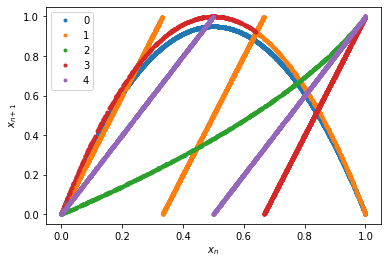

In [3]:
#some functions on [0,1]
def f1(x):
    return 4*x*(1-x)
def f2(x):
    return 3.8*x*(1-x)
def f3(x):
    return 3*x%1
def f4(x):
    return 2*x%1
def f5(y):
    r = 0.5
    return (1+r - np.sqrt((1+r)**2-4*r*y))/(2*r)


#generate some data from an IFS
n = 15000 #sample size
p = 0.5
A = np.zeros(n)
A[0]=rnd.random()
for i in range(n-1):
    samp = np.random.binomial(4, p, 1)[0]
    if samp ==0:
        A[i+1]=f1(A[i])
    elif samp == 1:
        A[i+1]=f2(A[i])
    elif samp ==2:
        A[i+1]=f3(A[i])
    elif samp ==3:
        A[i+1]=f4(A[i])
    else:
        A[i+1]=f5(A[i])
#

#construct ordered time delay embedding of dimension 2 (x_n, x_{n+1})
X = np.stack((A[:n-1],A[1:n]),axis = -1)
ind = np.lexsort((A[1:n],A[:n-1])) # sort on x coordinates from min to max values
X = X[ind]

#apply algorithm
test1 = find_piecewise_curves(X)
plt.rcParams['figure.dpi'] = 150

plt.figure()
for i in range(len(test1)):
    plt.plot(test1[i][:,0],test1[i][:,1],'.', label = i);
plt.xlabel('$x_n$')
plt.ylabel('$x_{n+1}$')
plt.legend()

#estimate sampling distribution of maps in IFS
p=[]
for i in range(len(test1)):
    p.append(len(test1[i])/len(X))
#print('p =', p)

#stimate transition matrix
def conditional_prob(curves):
    n = len(curves)
    mat = np.zeros((n,n))
    for i in range(n):
        for k in curves[i][:,1]:
            for j in range(n):
                if k in curves[j][:,0]:
                    mat[i,j] += 1
    for i in range(n):
        mat[i,:] = mat[i,:]/sum(mat[i,:])
    return mat

# print(conditional_prob(test1))
plt.savefig('sep v2')

#### flow maps

In [4]:
from scipy.integrate import solve_ivp

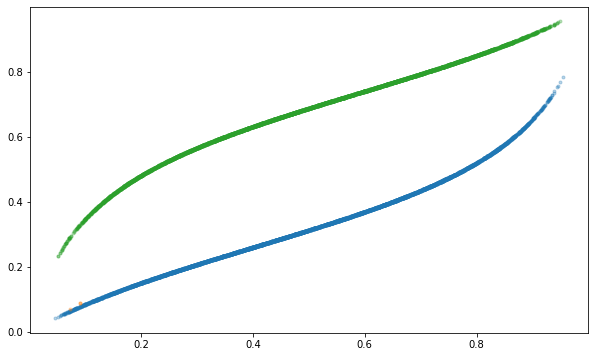

In [5]:
#some functions
def f2(x,r): 
    '''
    r dot
    x = theta
    r = radius
    '''
    return r*(1-r)**2#*np.exp(-(x%(2*np.pi)))

def g2(x,r):
    #r dot
    return -r**2*(1-r)#*np.exp(-(x%(2*np.pi)))

def f1(x,r):
    return  1 + (x%(2*np.pi) )

def g1(x,r):
    return 1 + (x%(2*np.pi) )

def F(t,X):
    x,r = X
    return (f1(x,r), f2(x,r))

def G(t,X):
    x,r = X
    return (g1(x,r), g2(x,r))

IC = np.array([0, np.random.uniform(0.25,0.75,1)[0]])
t = np.linspace(0,2,10000)
data = [IC[1]]
jumps = []
for i in range(10000):
    sample = np.random.randint(0,2)
    jumps.append(sample)
    if sample == 0:
        sol = solve_ivp(F,[0,2],IC, t_eval =t).y
    else:
        sol = solve_ivp(G,[0,2],IC, t_eval =t).y
    IC = np.array([0,sol[1][np.where(sol[0]%(2*np.pi)<0.0015)][-1]])
    data.append(IC[1])

#construct time delay embedding, sort on x-coords
X= np.stack((data[:-1],data[1:]),axis = -1)
ind = np.lexsort((data[1:],data[:-1])) # sort on x coordinates from min to max values
X = X[ind]

split = find_curves(X,eps = 0.1, eps_grad = 0.3)
plt.figure(figsize=(10,6))
for i in range(len(split)):
    plt.plot(split[i][:,0],split[i][:,1],'.',alpha = 0.3,label = i);
    
    

###### try learn the maps

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Epoch 1/30
4000/4000 [==============================] - 5s 1ms/step - loss: 9.3419
Epoch 2/30
4000/4000 [==============================] - 4s 991us/step - loss: 3.8886
Epoch 3/30
4000/4000 [==============================] - 4s 1ms/step - loss: 2.9925
Epoch 4/30
4000/4000 [==============================] - 4s 913us/step - loss: 2.5421
Epoch 5/30
4000/4000 [==============================] - 4s 913us/step - loss: 2.2798
Epoch 6/30
4000/4000 [==============================] - 4s 1ms/step - loss: 2.1067
Epoch 7/30
4000/4000 [==============================] - 4s 1ms/step - loss: 1.9941
Epoch 8/30
4000/4000 [==============================] - 4s 1ms/step - loss: 1.8954
Epoch 9/30
4000/4000 [==============================] - 4s 979us/step - loss: 1.8233
Epoch 10/30
4000/4000 [==============================] - 4s 897us/step - loss: 1.7408
Epoch 11/30
4000/4000 [==============================] - 4s 897us/step - loss: 1.6872
Epoch 12/30
4000/4000 [==============================] - 4s 902us/step - 

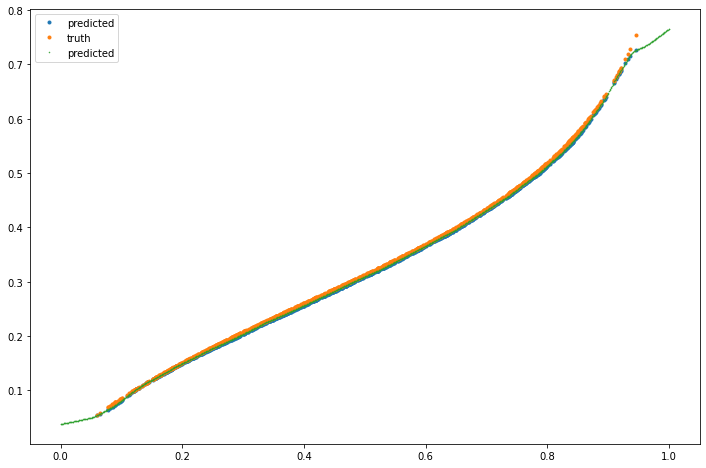

In [7]:
#input in to dense layer must be 1D!
#define MLP
mlp = Sequential([
    Dense( 128, activation = 'relu'),
    Dense( 128, activation = 'relu'),
    Dense(1,activation = 'sigmoid')
    
])

#build mlp
x = tf.random.normal((1,1))
y = mlp(x)

#shuffle data
p = np.random.permutation(np.arange(0,len(split[0]),1))
split[0] = split[0][p]
len(split[0])

#assign training and test set
x_train = tf.convert_to_tensor(split[0][:4000,0])
y_train = tf.convert_to_tensor(split[0][:4000,1])
x_test = tf.convert_to_tensor(split[0][4000:,0])
y_test = tf.convert_to_tensor(split[0][4000:,1])

#train mlp
mlp.compile(loss = 'mape' )
history = mlp.fit(x_train, y_train, epochs = 30, batch_size = 1)

#plot performance
preds = mlp.predict(x_test)
plt.figure(figsize=(12,8))
plt.plot(x_test.numpy(), preds,'.', label = 'predicted')
plt.plot(x_test.numpy(), y_test.numpy(),'.', label = 'truth')

preds = mlp.predict(tf.convert_to_tensor(np.linspace(0,1,1000)))
plt.plot(np.linspace(0,1,1000), preds,'.',markersize = 1, label = 'predicted')
plt.legend()

## Separating 2D maps

In [8]:
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors

In [9]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    theta = np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
    return min(theta,np.pi - theta)


def progressbar(i,n,refresh_rate = 1, i_start = 0):
    '''
    Approximates how far through the computation you are, by showing a percentage of total loops that have been computed
    i = loop index~~~~~~~~~~~~~~~~
    n = amount of iterations (max loop index + 1 if i_start = 0)
    refresh_rate = how often you would like to update the percentage (useful)
    i_start = start value of loop
    '''
    output = (i-i_start)/refresh_rate
    if (int(output)==output):
        print(str(np.round((i+1-i_start)/n*100,2))+'%', end ="\r")
        

#function implementing the algorithm outlined above
def find_curves_2D(X,eps = 0.05,eps_grad = 0.1):
    '''
    X the (n-1) - dimensional surface
    eps
    eps_grad
    separation the separation bound for recursion algorithm
    '''
    n = len(X)
    start = np.random.choice(np.arange(n))
    A1 = [X[start,:]]
    A2 = []
    df = pd.DataFrame(X)
    normals = []
    nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X) #n_neighbours = dimension
    distances, indices = nbrs.kneighbors([X[start,:]])
    while len(A1) + len(A2) < n:
        progressbar(len(A1) + len(A2),n)
        if len(normals)>0: 
            nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(df.to_numpy())
            distances, indices = nbrs.kneighbors(A1)
            #new point being examined
            i2 = df.iloc[indices[np.unravel_index(np.argmin(distances, axis=None), distances.shape)]].name
            #nearest neighbour in A1
            i1 = A1[np.argmin(distances, axis=None)]
            #normal at A1
            normal = normals[np.argmin(distances, axis=None)]
            
            if distances[np.unravel_index(np.argmin(distances, axis=None), distances.shape)]< eps:
                #get second nearest neighbour in A1
                distances[np.unravel_index(np.argmin(distances, axis=None), distances.shape)] = 1000
                i = A1[np.argmin(distances, axis=None)]
                new_normal = np.cross((i1- X[i2,:]), (i - X[i2,:]))
                if angle_between(normal,new_normal)<eps_grad:
                    normals.append(new_normal)
                    A1.append(X[i2,:])
                    i = i2
                    df = df.drop(i)
                else:
                    A2.append(X[i2,:])
                    df = df.drop(i2)
            else:
                A2.append(X[i2,:])
                df = df.drop(i2)
            
            
            
        else:
            i = start
            i1 = indices[0][1]
            i2 = indices[0][2]
            A1.extend([X[i2,:],X[i1,:]])
            normal = np.cross((X[i1,:] - X[i,:]), (X[i2,:] - X[i,:]))
            normals.append(normal)
            normal = np.cross((X[i1,:] - X[i2,:]),
                              (X[i,:] - X[i2,:]))
            df = df.drop([i,i1,i2])

            normals.append(normal)
            normal = np.cross((X[i2,:] - X[i1,:]),
                              (X[i,:] - X[i1,:]))
            normals.append(normal)
            i = i2
    
    A1 = np.stack(A1,axis = 0)
    A2 = np.stack(A2,axis = 0)
    
    #recursively ontinue identify distinct curves from leftover unassigned points
    if len(A2)<10:
        return [A1] + [A2] 
    else: return [A1] + find_curves_2D(A2)

    
### sometimes better to do recursion manually
#function implementing the algorithm outlined above
def find_curves_2D_manually(X,eps = 0.05,eps_grad = 0.1):
    '''
    X the (n-1) - dimensional surface
    eps
    eps_grad
    separation the separation bound for recursion algorithm
    '''
    n = len(X)
    start = np.random.choice(np.arange(n))
    A1 = [X[start,:]]
    A2 = []
    df = pd.DataFrame(X)
    normals = []
    nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X) #n_neighbours = dimension
    distances, indices = nbrs.kneighbors([X[start,:]])
    while len(A1) + len(A2) < n:
        progressbar(len(A1) + len(A2),n)
        if len(normals)>0: 
            nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(df.to_numpy())
            distances, indices = nbrs.kneighbors(A1)
            #check at least one point is within distance epsilon to assigned points
            if np.min(distances)>eps:
                break
            
            #new point being examined
            i2 = df.iloc[indices[np.unravel_index(np.argmin(distances, axis=None), distances.shape)]].name
            #nearest neighbour in A1
            i1 = A1[np.argmin(distances, axis=None)]
            #normal at A1
            normal = normals[np.argmin(distances, axis=None)-1]
            #get second nearest neighbour in A1
            distances[np.unravel_index(np.argmin(distances, axis=None), distances.shape)] = 1000
            i = A1[np.argmin(distances, axis=None)]
            if distances[np.unravel_index(np.argmin(distances, axis=None), distances.shape)]< eps:
                new_normal = np.cross((i1- X[i2,:])/
                                      np.linalg.norm(i1 -X[i2,:]),
                                      (i - X[i2,:])/np.linalg.norm(i -X[i2,:]))
                if angle_between(normal,new_normal)<eps_grad:
                    normals.append(new_normal)
                    A1.append(X[i2,:])
                    i = i2
                    df = df.drop(i)
                else:
                    A2.append(X[i2,:])
                    df = df.drop(i2)
            else:
                A2.append(X[i2,:])
                df = df.drop(i2)
            
            
            
        else:
            i = start
            i1 = indices[0][1]
            i2 = indices[0][2]
            A1.extend([X[i2,:],X[i1,:]])
            normal = np.cross((X[i1,:] - X[i2,:])/np.linalg.norm(X[i1,:] -X[i2,:]),
                              (X[i,:] - X[i2,:])/np.linalg.norm(X[i,:] -X[i2,:]))
            df = df.drop([i,i1,i2])

            normals.append(normal)
            normal = np.cross((X[i2,:] - X[i1,:])/np.linalg.norm(X[i2,:] -X[i1,:]),
                              (X[i,:] - X[i1,:])/np.linalg.norm(X[i,:] -X[i1,:]))
            normals.append(normal)
            i = i2
    A2 = np.stack(A2,axis = 0)
    A2 = np.vstack((A2,df.to_numpy()))
    return A1, A2


#### Example  

<IPython.core.display.Javascript object>


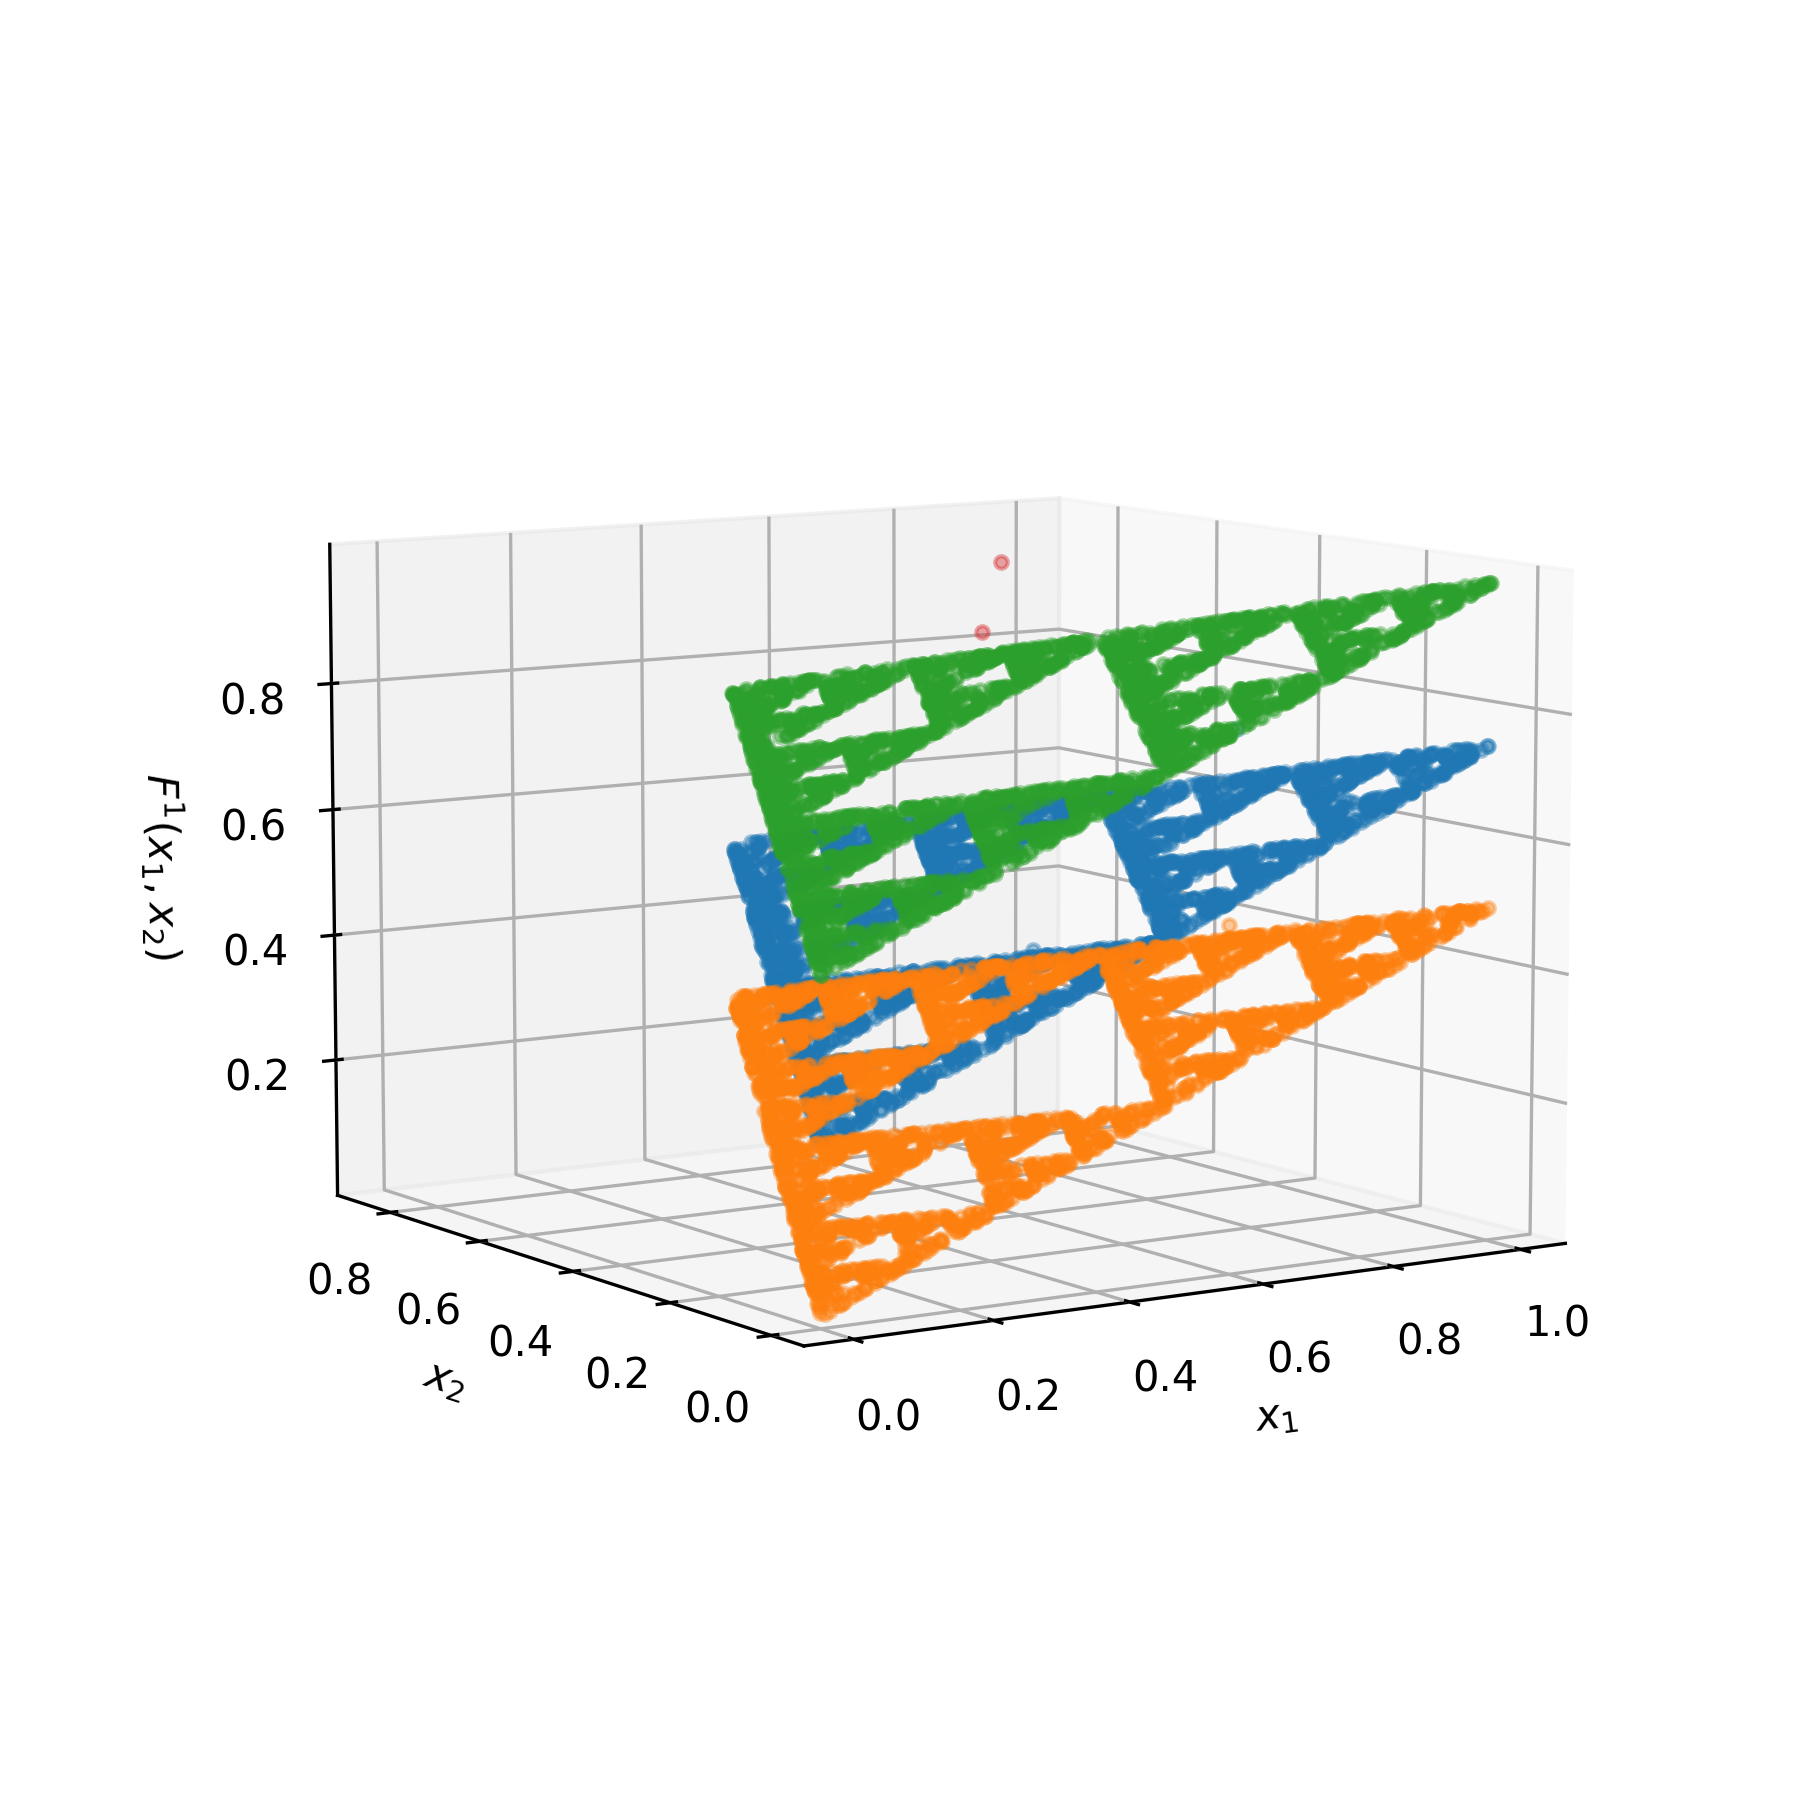

Text(0.5, 0, '$F^1(x_1,x_2)$')

In [10]:
#some maps
p1 = np.array([0,0])
p2 = np.array([1,0])
p3 = np.array([0.5,np.sqrt(3)/2])

def f1(x):
    return [x[0]/2 ,x[1]/2]
def f2(x):
    return [(x[0]+ p2[0])/2 ,(x[1]+p2[1])/2]
def f3(x):
    return  [(x[0]+ p3[0])/2 ,(x[1]+p3[1])/2]

#generate some date
n = 10000 #sample size
A = np.zeros((n,2))
A[0,:]=np.random.uniform(size = 2)
for i in range(n-1):
    samp = np.random.choice(np.arange(3),size = 1)
    if samp ==0:
        A[i+1]=f1(A[i])
    elif samp ==1:
        A[i+1]=f2(A[i])
    else:
        A[i+1]=f3(A[i])
        
#get data into right format
A2 = np.stack((A[:-1,0],A[:-1,1],A[1:,0]),axis = -1)
#apply separation algorithm 
test = find_curves_2D(A2,eps=0.5,eps_grad= 0.25)  


%matplotlib notebook
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
for i in range(len(test)):
    if len(test[i])>1:
        ax.plot(test[i][:,0],test[i][:,1],test[i][:,2],'.',alpha = 0.4);

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$F^1(x_1,x_2)$')

## Detection and separation algorithm by Z Alexander et al. 
Code for the algorithms presented in Iterated
function system models in data analysis: Detection and separation

Zachary Alexander, James D. Meiss, Elizabeth Bradley, and Joshua Garland. Iterated
function system models in data analysis: Detection and separation. Chaos, 22:
023103, 2012. URL https://doi.org/10.1063/1.3701728.


In [12]:
#henon map
def henon1(x):
    return [x[1] + 1 - 1.4*x[0]**2, 0.3 * x[0]]

def henon2(x):
    return [x[1] + 1 - 1.2*(x[0] - 0.2)**2, - 0.2 * x[0]  ]

#generate data
rnd.seed(1000)
n = 30000 #sample size
p = 0.5
H = np.zeros((n,2))
H[0,:]=(0.63986, -0.12797)
H11 = np.zeros((n,2))
H22 = np.zeros((n,2))
count1 = 0
count2 = 0
zero_jumps = []
one_jumps = []
for i in range(n-1):
    samp = np.random.binomial(1, p, 1)[0]
    if samp ==0:#
        H[i+1,:]=henon1(H[i,:])
        H11[count1,:] = H[i+1,:]
        count1 += 1
        zero_jumps.append(i+1)
    else:
        H[i+1,:]=henon2(H[i,:])
        H22[count2,:] = H[i+1,:]
        count2 += 1
        one_jumps.append(i+1)
H11 = H11[np.sum(np.abs(H11), axis = 1) > 0]
H22 = H22[np.sum(np.abs(H22) ,axis = 1) > 0]


plt.rcParams['figure.dpi'] = 150
plt.plot(H11[:,0],H11[:,1],'.',markersize=0.5)
plt.plot(H22[:,0],H22[:,1],'.',markersize=0.5)

### Detection

In [17]:
import scipy.spatial as spatial


In [13]:
nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto',metric='euclidean').fit(H)
distances, indices = nbrs.kneighbors(H)

<IPython.core.display.Javascript object>


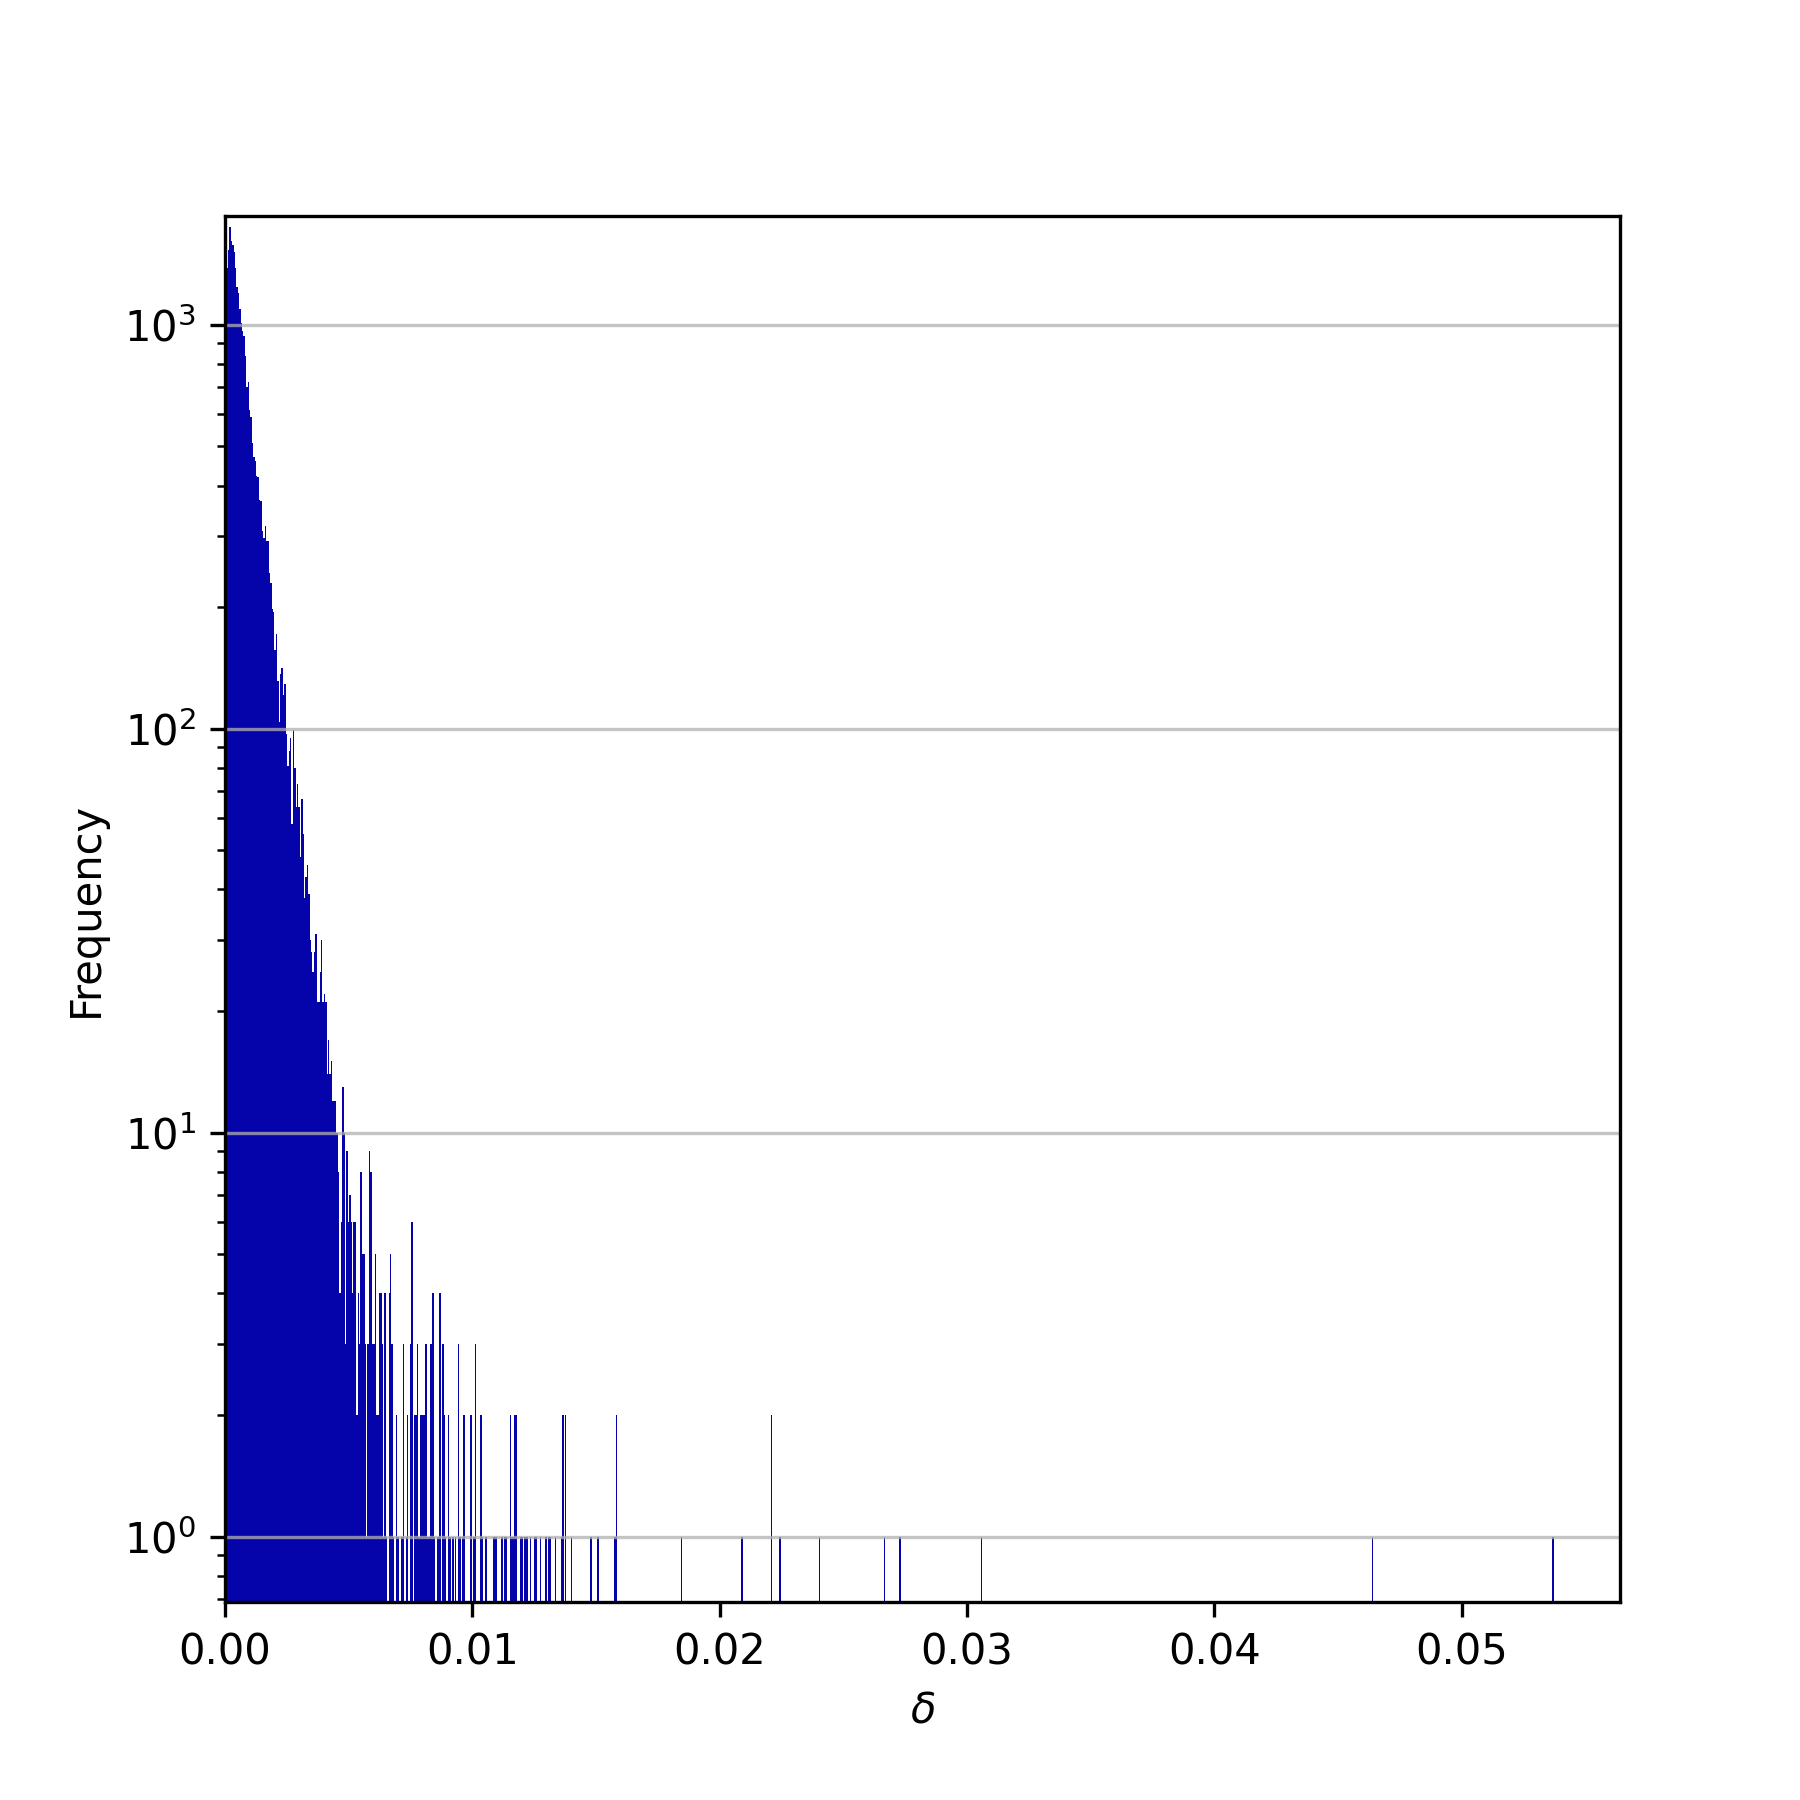

In [14]:
plt.figure(figsize = (6,6))                           
n, bins, patches = plt.hist(x=distances[:,1],bins='auto', color='#0504aa',log=True)
#plot on a log-scale is key
plt.grid(axis='y', alpha=0.75)
plt.xlabel('$\delta$')
plt.ylabel('Frequency')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 + 100 if maxfreq % 10 else maxfreq + 10)
plt.xlim(xmin = 0);

<IPython.core.display.Javascript object>


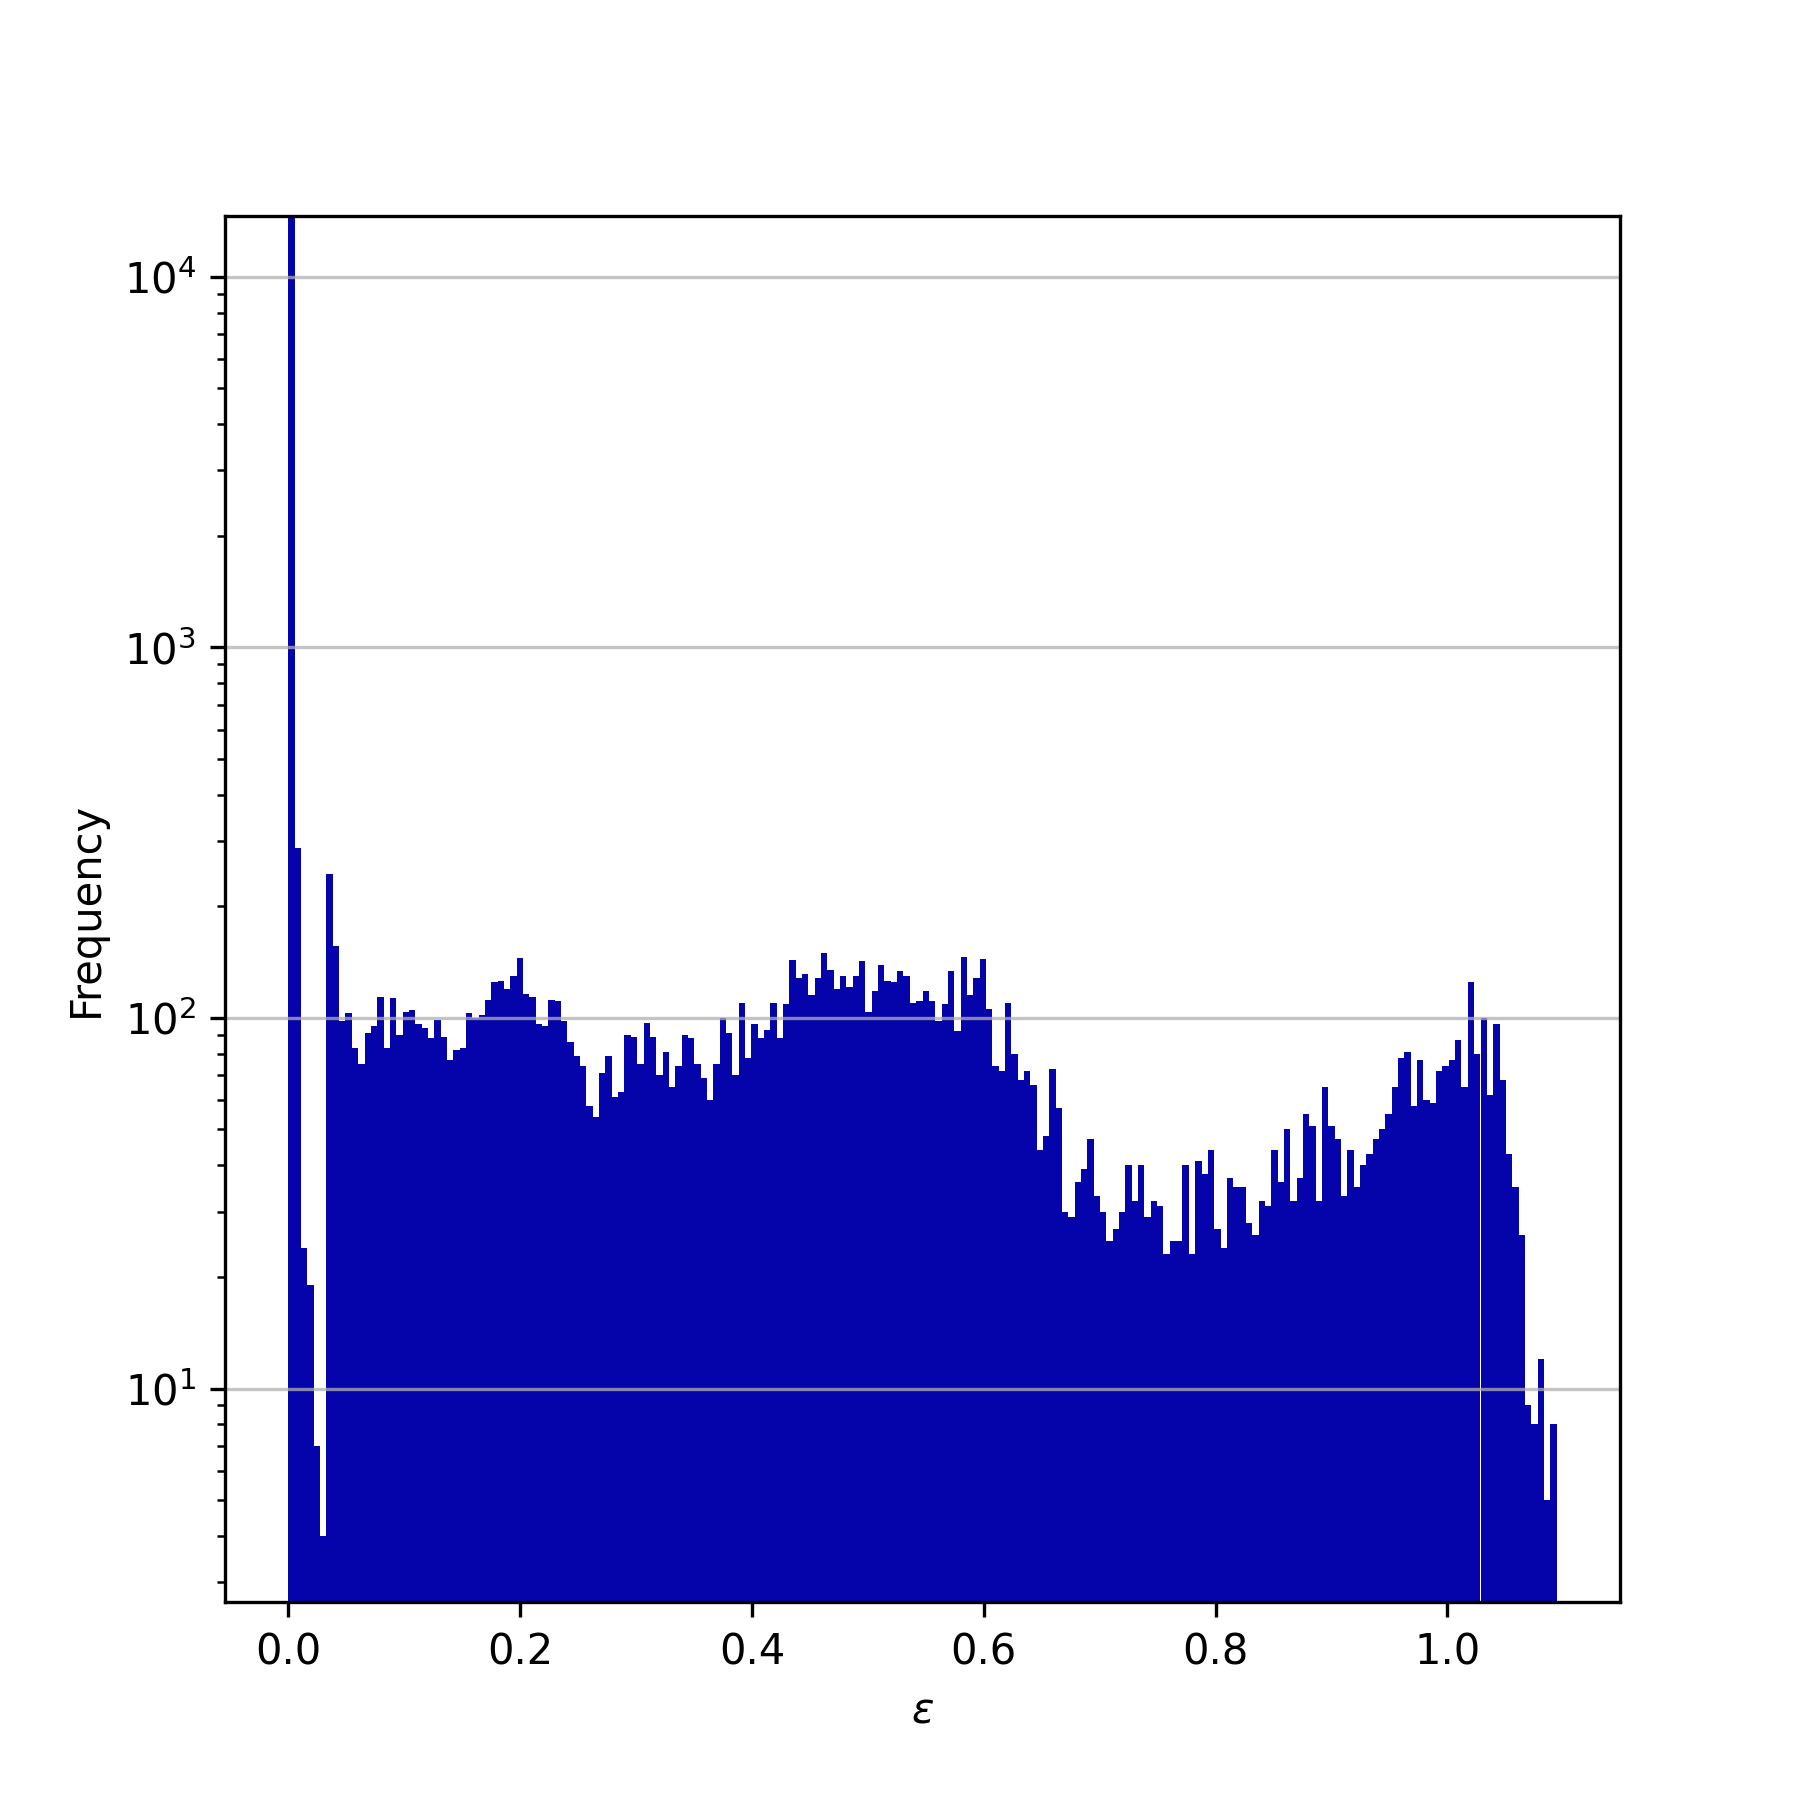

(2.654544519456916, 14580.0)

In [15]:
e_distances = np.zeros(len(indices)-1)
for i in range(len(indices)-1):
    a = indices[i][0]
    b = indices[i][1]
    if b!= len(indices)-1:
        e_distances[i] = np.linalg.norm(H[a+1]-H[b+1])

plt.figure(figsize = (6,6))                           
n, bins, patches = plt.hist(x=e_distances,bins=200, color='#0504aa',log=True)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('$\epsilon$')
plt.ylabel('Frequency')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 + 100 if maxfreq % 10 else maxfreq + 10)


In [19]:
#code to produce data from figure 4
e_components = []
delta = 0.001

point_tree = spatial.cKDTree(H)
for eps in np.linspace(0.001,0.02,6):
    print(eps)
    components= []

    for i in range(0,len(indices)-1,5):
        #apply shift map to N_5(X_t)
        a = point_tree.query_ball_point(H[i], delta) 

        if np.any(len(indices)-1 in a) == False:
            comps = 1
            #find distances between each point in the image
            tree = spatial.cKDTree([H[j+1] for j in a], leafsize=100)
            nns = tree.query([H[j+1] for j in a], k=len(a) )
            dists,_ = nns
            
            #if all distances < eps then only one component
            if np.max(dists)< eps:
                components.append(comps)

            #else find number of eps connected components
            else:
                while np.max(dists) > eps:
                    comps +=1
                    #find i-jth coordinates of the matrix
                    argmax = np.unravel_index(np.argmax(dists), np.array(dists).shape)
                    cols = [_[_[argmax]][j] for j in range(len(dists)) if dists[_[argmax]][j]<eps ]
                    a = [a[j] for j in range(len(a)) if j not in cols]
                    tree = spatial.cKDTree([H[j+1] for j in a], leafsize=100)
                    nns = tree.query([H[j+1] for j in a], k=len(a) )
                    dists,_ = nns

                components.append(comps)
    e_components.append(components)

0.001
0.0048000000000000004
0.0086
0.012400000000000001
0.0162
0.02


<IPython.core.display.Javascript object>


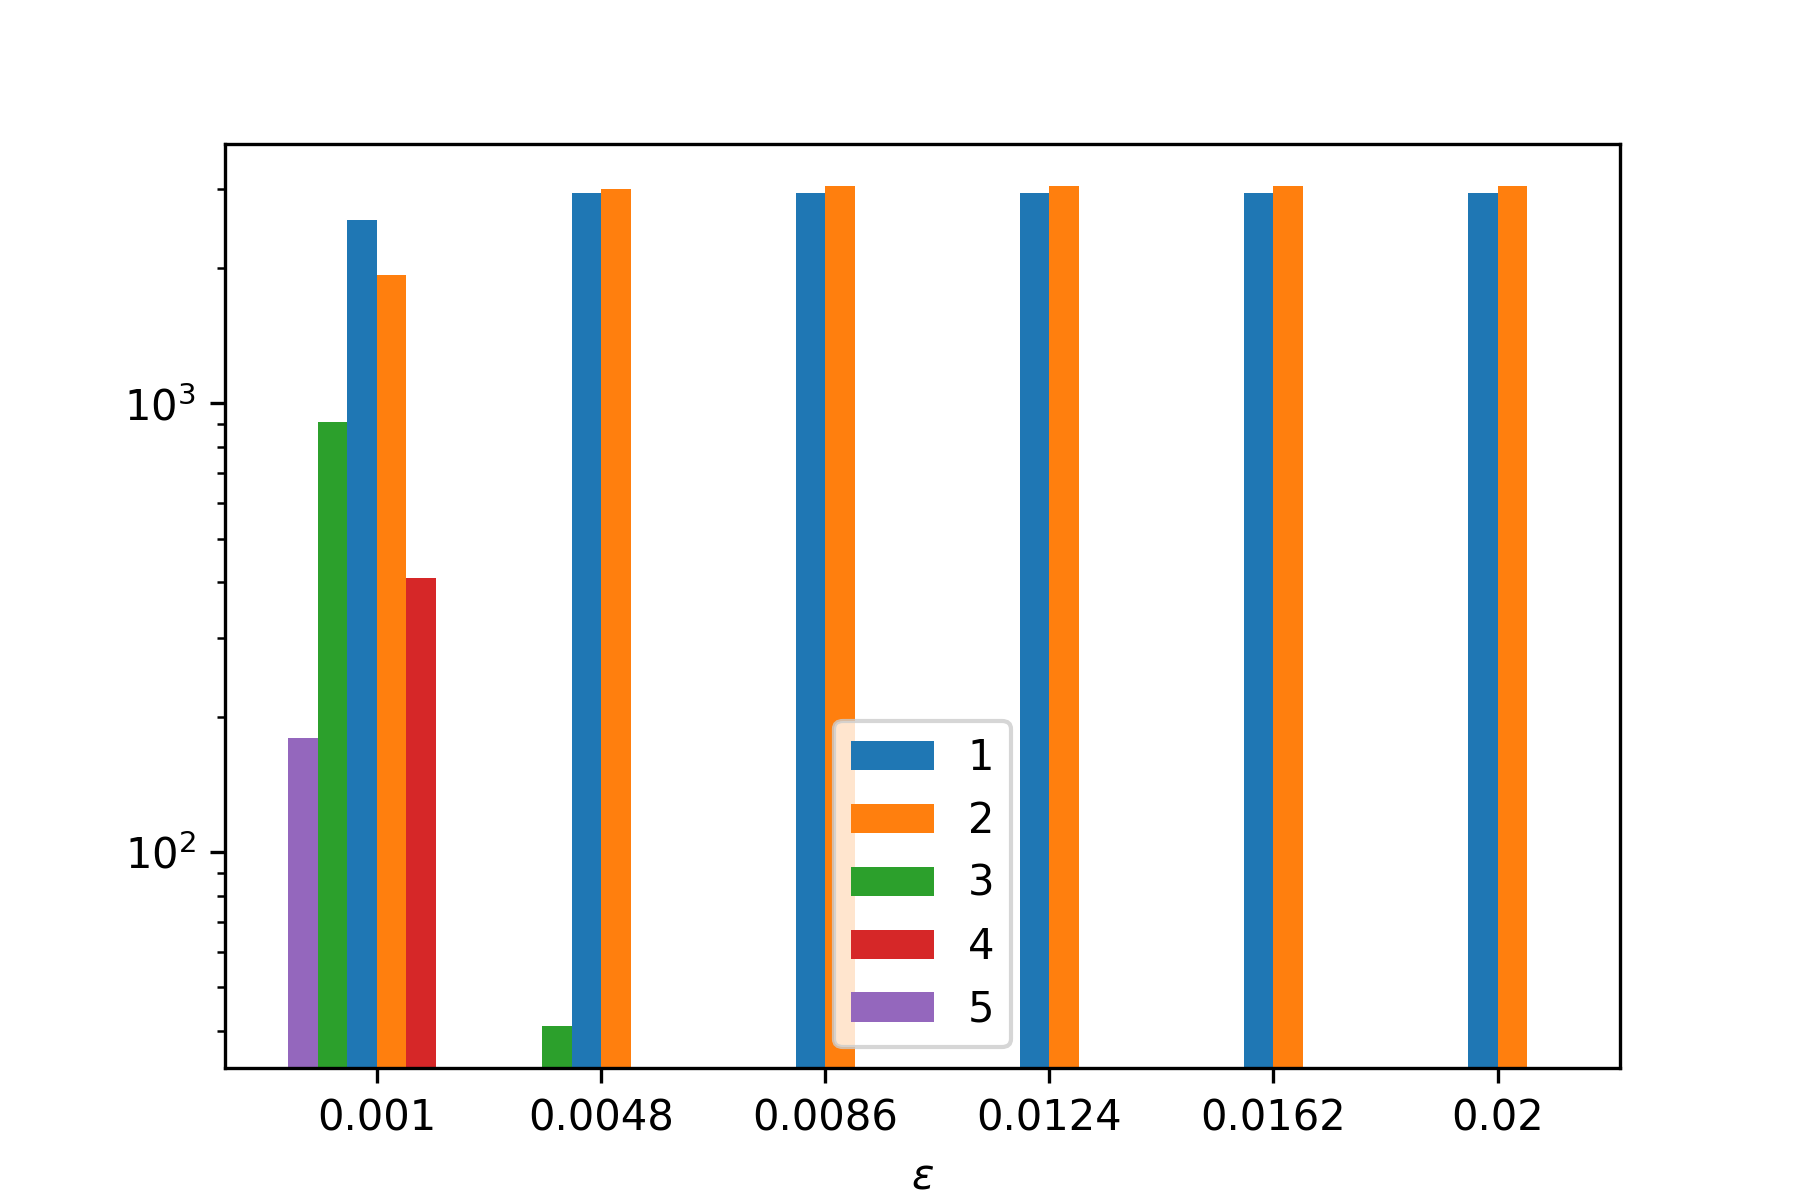

In [24]:
# plot histogram
width = 0.00025
X = np.linspace(0.001,0.02,6)
X_axis = X
hist = np.zeros((len(X),5))
for i in range(len(X)):
    hist[i,:] = np.histogram(e_components[i],bins=range(7))[0][1:]

plt.figure(figsize=(6,4))
plt.bar(X_axis - 1*width, hist[:,0], width = 2*width,log=True,label=1)
plt.bar(X_axis + 1*width, hist[:,1], width = 2*width,log=True,label=2)
plt.bar(X_axis - 3*width, hist[:,2], width = 2*width,log=True,label=3)
plt.bar(X_axis + 3*width, hist[:,3], width = 2*width,log=True,label=4)    
plt.bar(X_axis - 5*width, hist[:,4], width = 2*width,log=True,label=5)


plt.xticks(X_axis, np.round(X,decimals=5))
plt.xlabel('$\epsilon$')
plt.legend();

### Separation

In [25]:
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csr_matrix

<IPython.core.display.Javascript object>


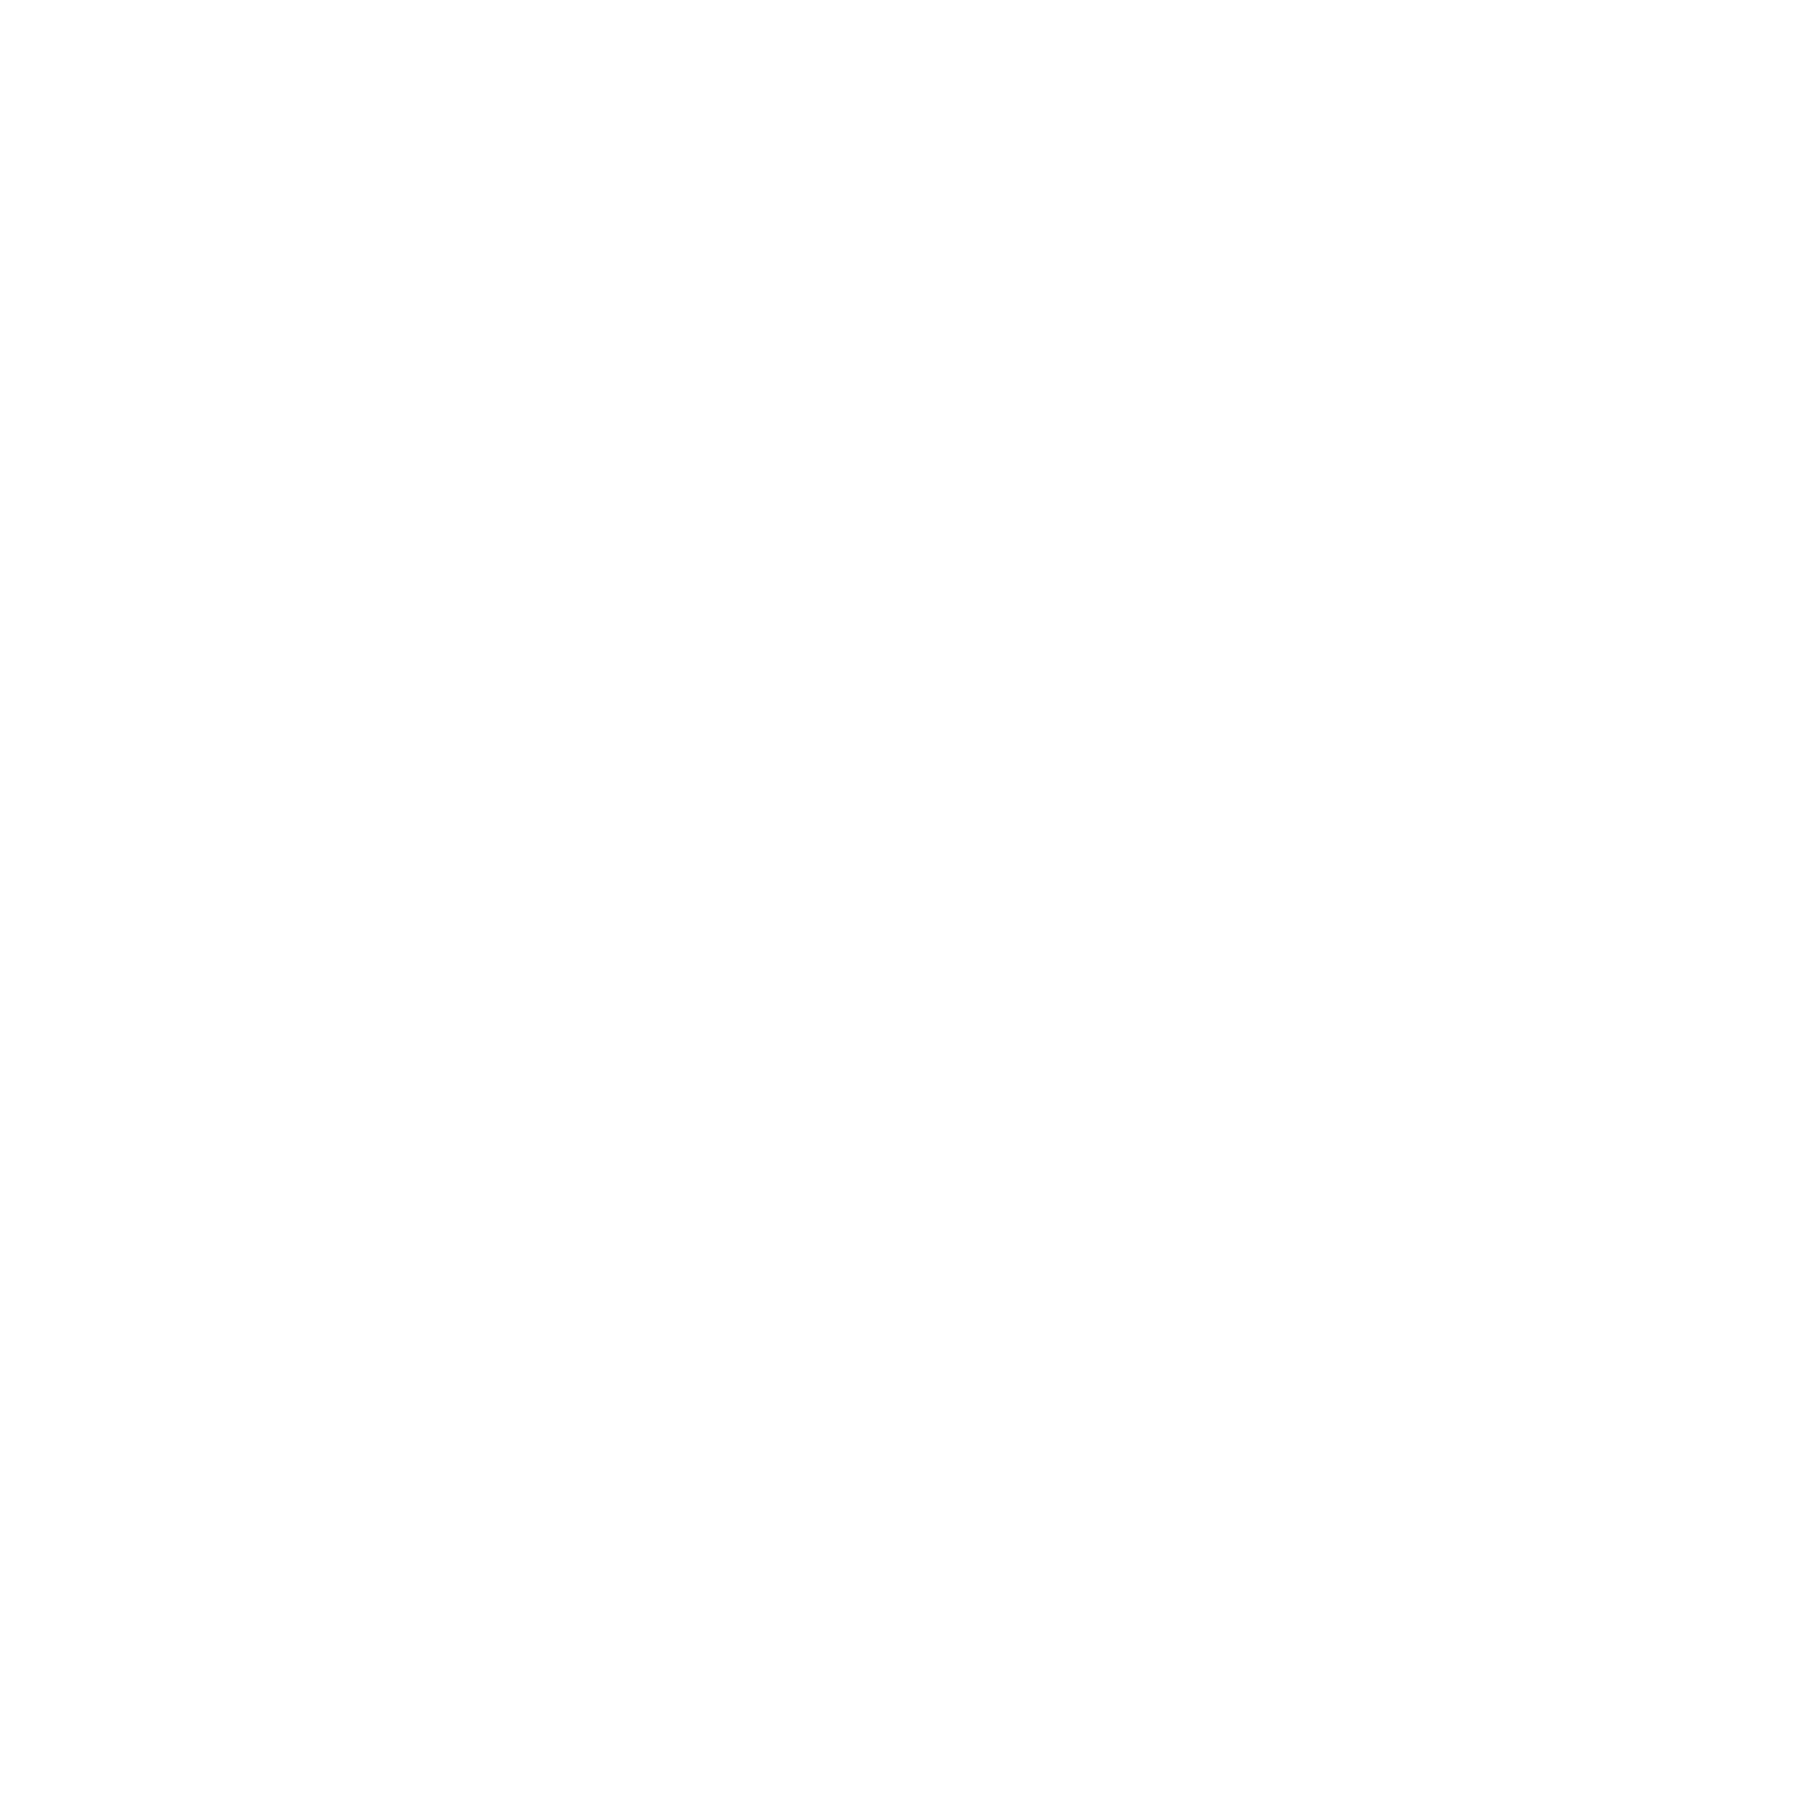

<IPython.core.display.Javascript object>


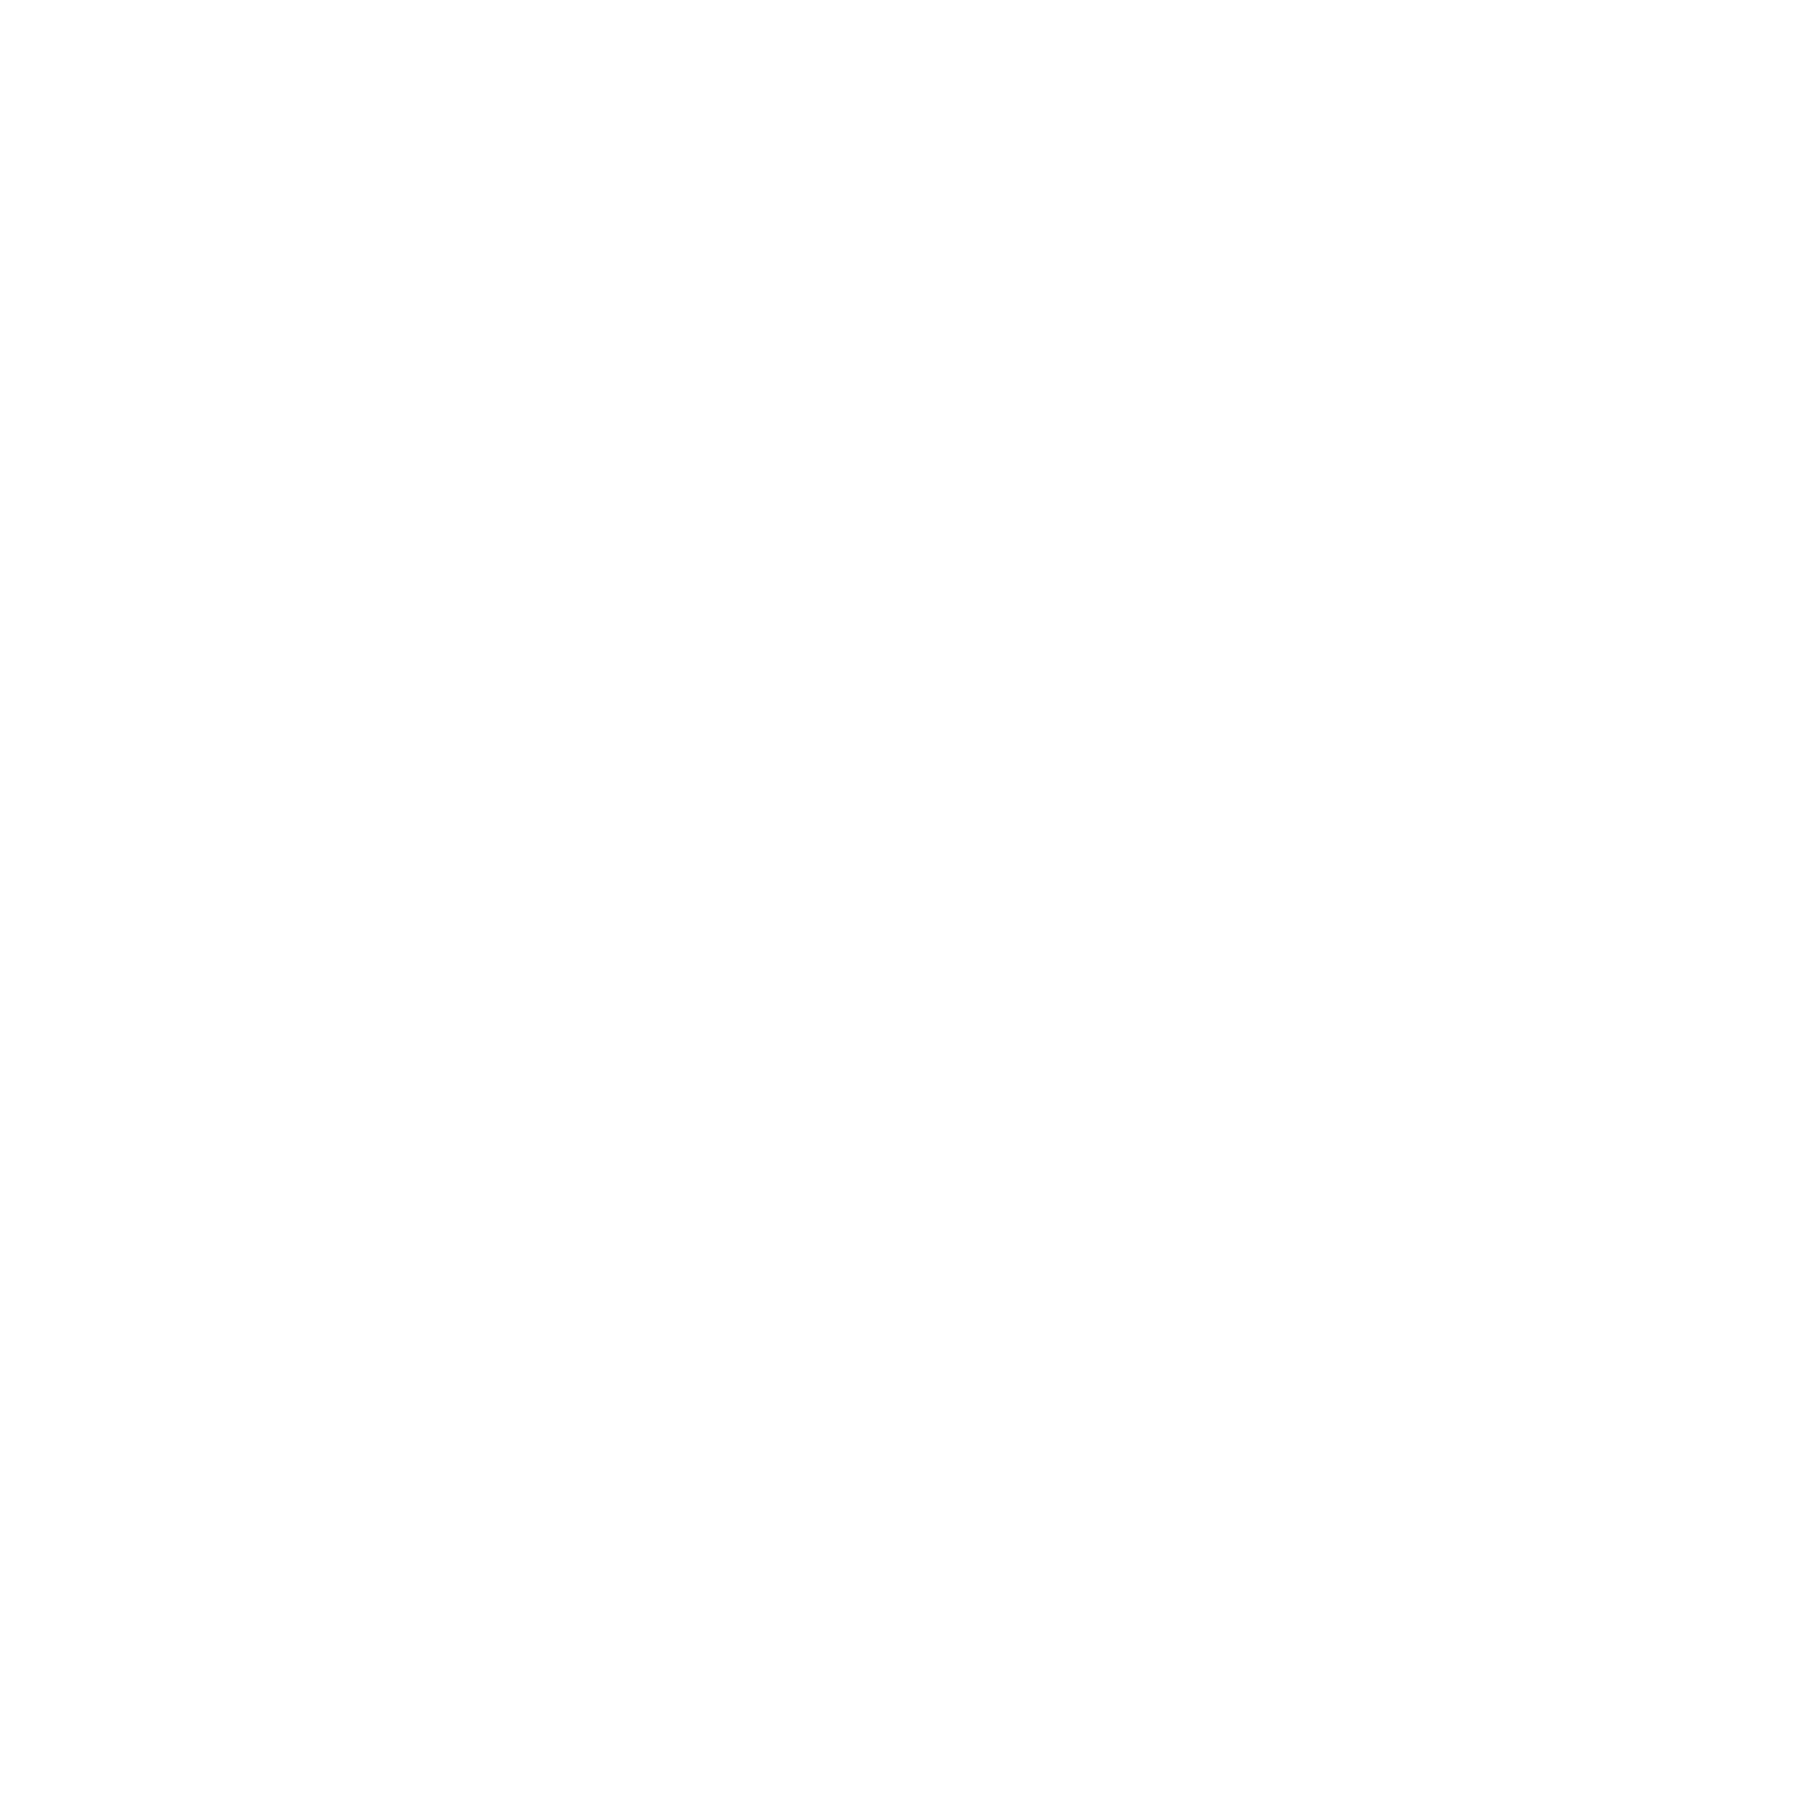

<IPython.core.display.Javascript object>


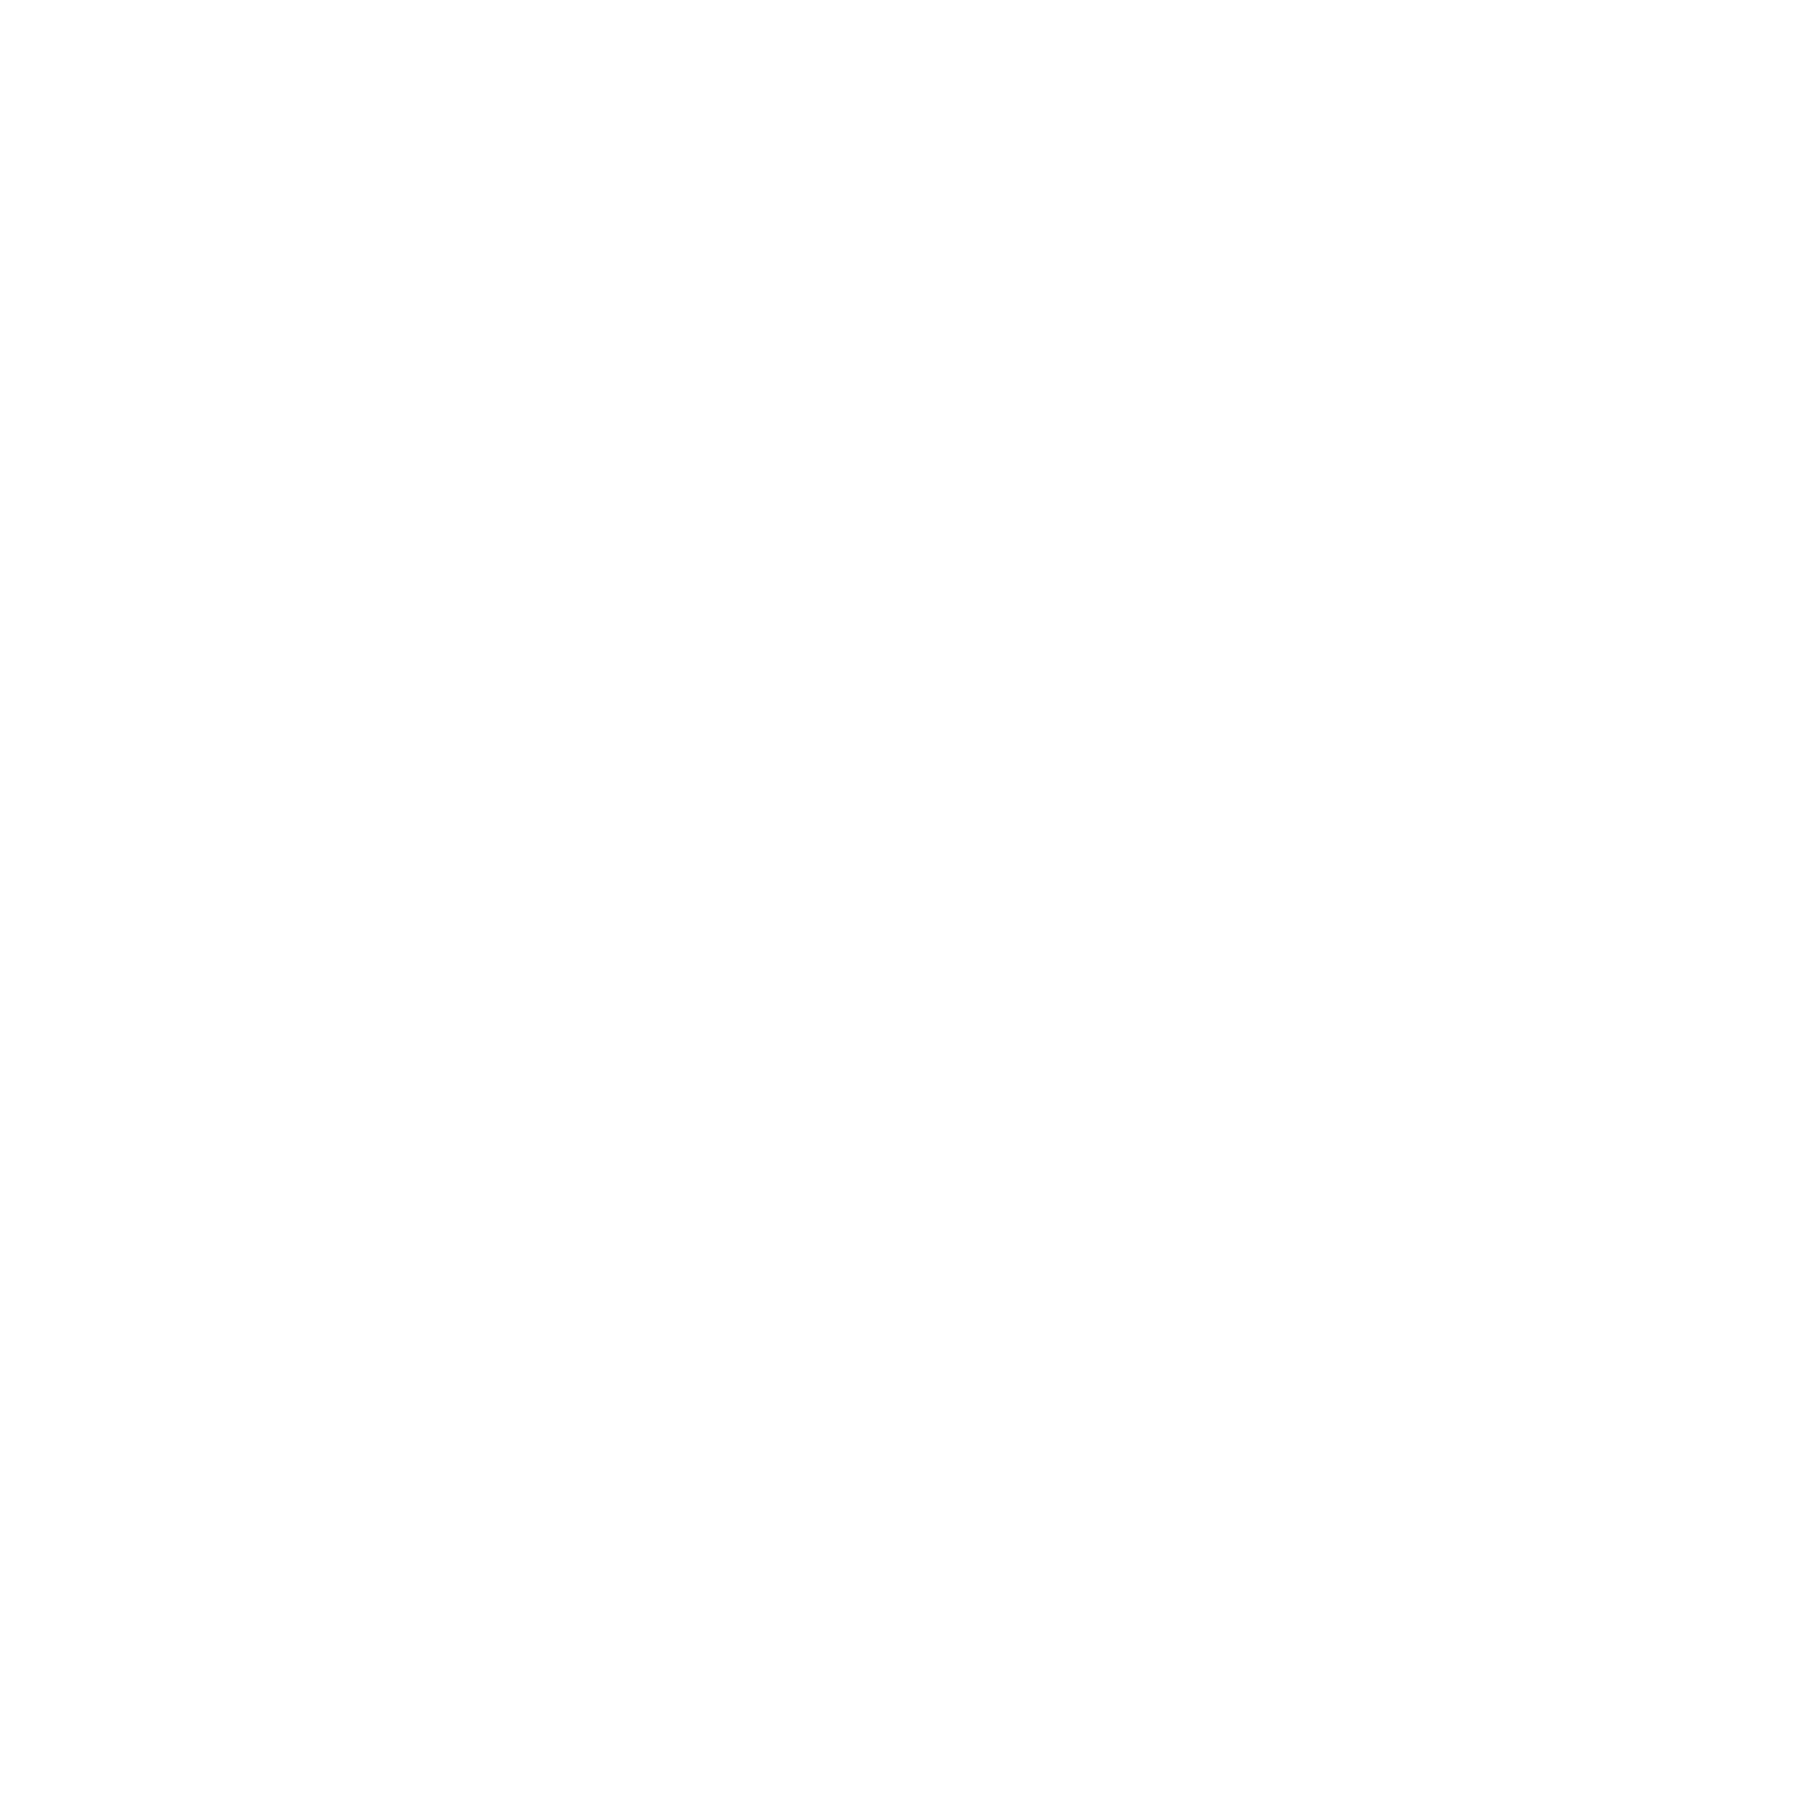

<IPython.core.display.Javascript object>


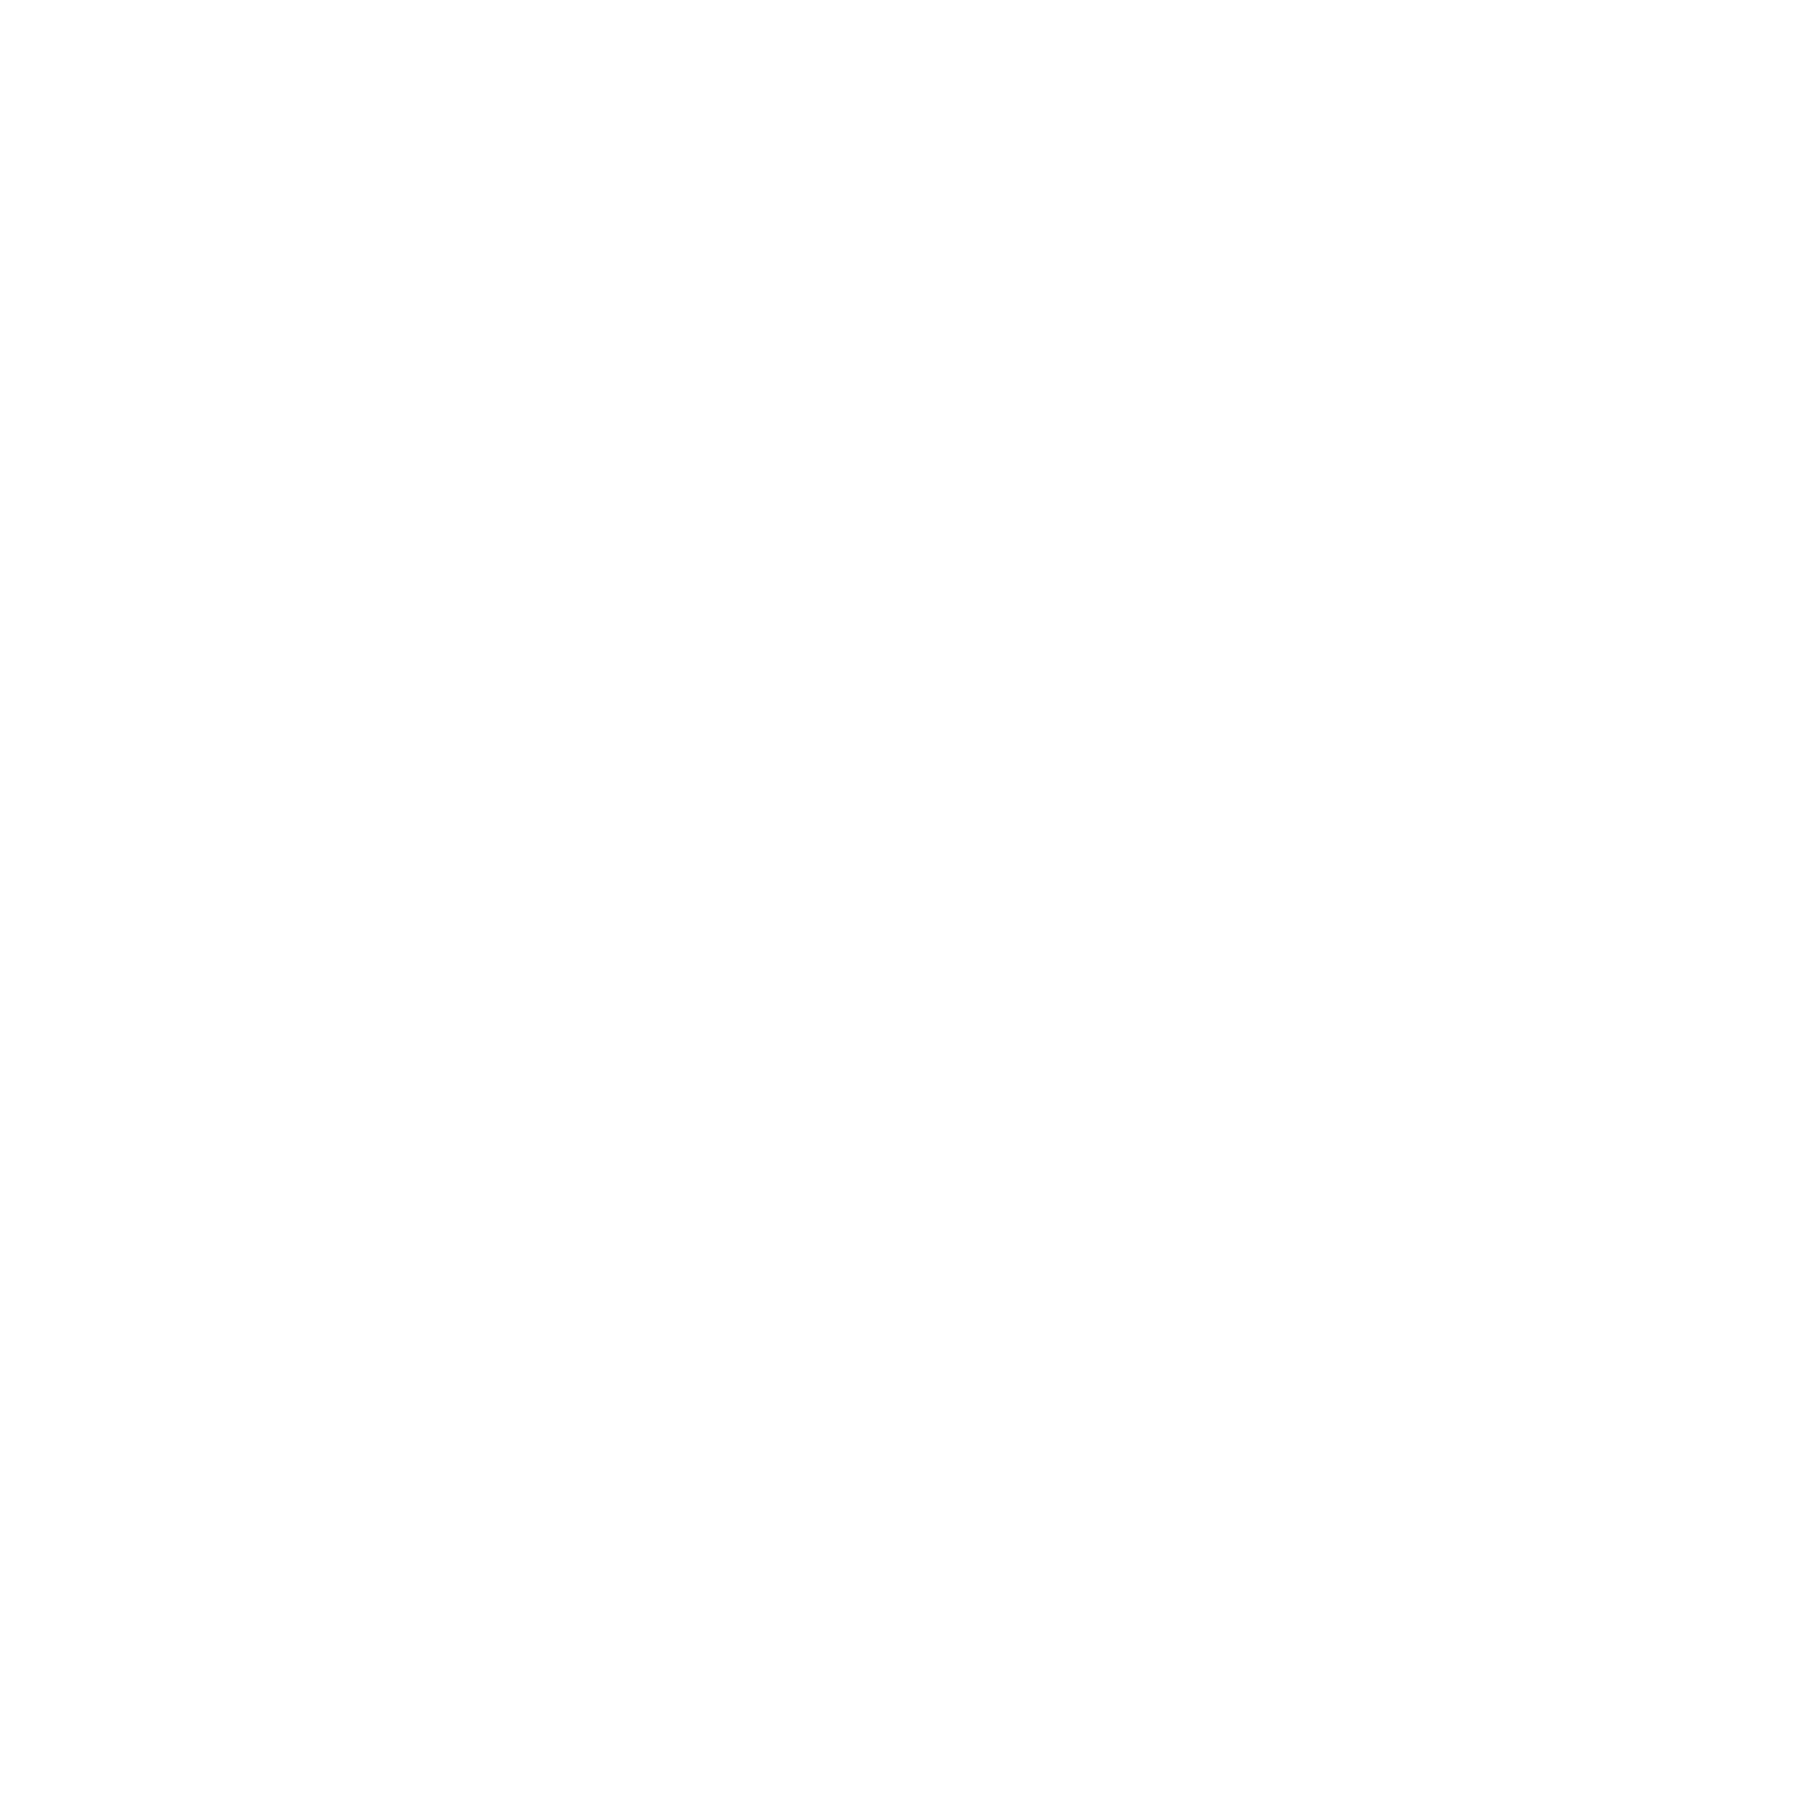

<IPython.core.display.Javascript object>


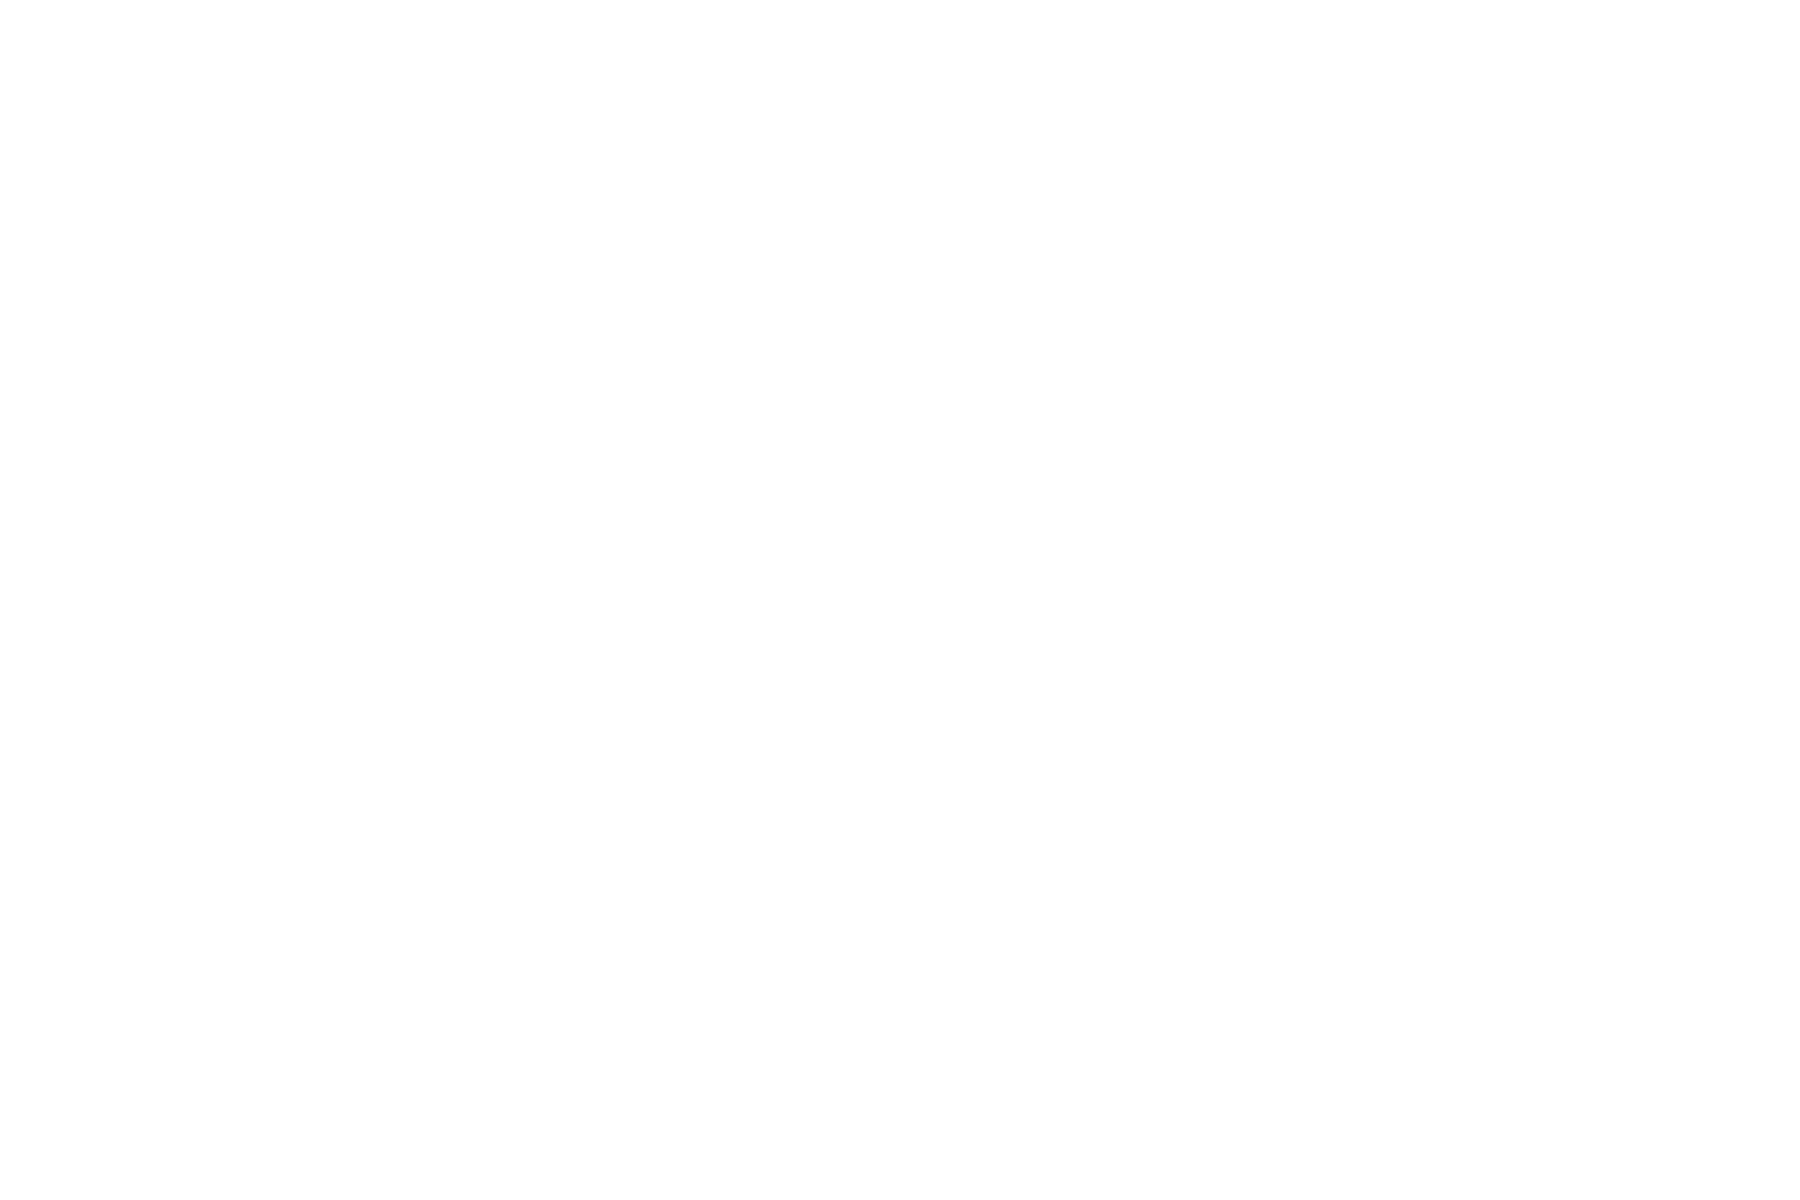

In [26]:
%matplotlib inline

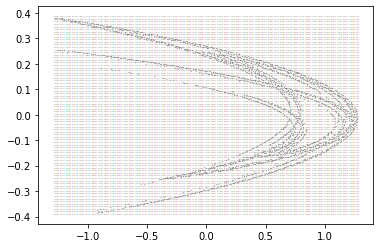

In [28]:
#visualisation of step 1
delta = 0.03
max_y = np.max(H[:,1])+0.005
min_y = np.min(H[:,1])-0.005
max_x = np.max(H[:,0])+0.005
min_x = np.min(H[:,0])-0.005
nx = round((max_x - min_x)/delta*3)
ny = round((max_y - min_y)/delta*3)
x = np.linspace(min_x, max_x, nx)
y = np.linspace(min_y, max_y, ny)
xv, yv = np.meshgrid(x, y)

#could be optimized as there are many boxes for which there are no points
count3 = -1
boxes = np.zeros(((nx-1)*(ny-1),4))
for m in range(nx-1):
        for n in range(ny-1):
            count3+=1
            boxes[count3,:] = (x[m], x[m+1],y[n], y[n+1])
boxes



#get one point from each grid
Y = []
for i in range(count3+1):  
    grid_intersect = np.where(np.logical_and(np.logical_and(H[:,0]>=boxes[i][0], H[:,0]<=boxes[i][1])
                                  ,np.logical_and(H[:,1]>=boxes[i][2], H[:,1]<=boxes[i][3])))
    if grid_intersect[0].size > 0:
        Y.append(grid_intersect[0][0])

# Visualise set y
plt.plot(xv, yv,'o',markersize=0.1);
plt.plot(H[Y,0],H[Y,1],'.',markersize=0.5)

In [29]:
#code for step 2
def progressbar(i,n,refresh_rate = 1, i_start = 0):
    '''
    Approximates how far through the computation you are, by showing a percentage of total loops that have been computed
    i = loop index
    n = amount of iterations (max loop index + 1 if i_start = 0)
    refresh_rate = how often you would like to update the percentage (useful)
    i_start = start value of loop
    '''
    output = (i-i_start)/refresh_rate
    if (int(output)==output):
        print(str(np.round((i+1-i_start)/n*100,2))+'%', end ="\r")
        
# construct delta radius balls around ecah point in Y
# remove y in Y if delta radius ball only contains y


delta_balls = []

point_tree = spatial.cKDTree(H)
medians = []
epsilon_balls = []
epsilon_trees = []
count = -1
for y in Y:
    count+=1
    progressbar(count,len(Y))
    #delta ball
    delta_ball = point_tree.query_ball_point(H[y,:], delta)
    if len(H)-1 in delta_ball:
        delta_ball.remove(len(H)-1)
    
    if len(delta_ball)>1:
        #store for future use
        delta_balls.append(delta_ball)
        #compute distances between each of the shifted points
        tree = spatial.cKDTree([H[j+1] for j in delta_ball], leafsize=100)
        nns = tree.query([H[j+1] for j in delta_ball], k=len(delta_ball) )
        dists,_ = nns
        dists2 = np.zeros(np.shape(_))
        #construct adjacency matrix with euclidean weights
        for i in range(len(dists)):
            dists2[i,:] =  dists[np.where(_==i)]
        #find minimum spanning tree and then median length
        epsilon_balls.append(dists2)
        dists = minimum_spanning_tree(dists2).todense()
        epsilon_trees.append(dists)
        medians.append(np.median(dists[np.where(dists > 0)].tolist()[0]))
e_bar = np.mean(medians)
e_bar


0.003069544135745626

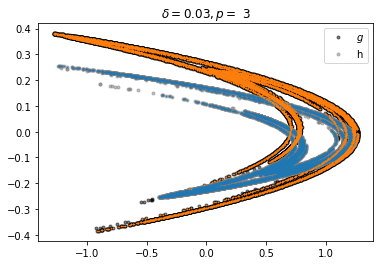

In [30]:
#code for step 3
#paper uses persistence parameter p = 3
components = []
p = 3
N = 2
for i in range(len(epsilon_trees)):
    progressbar(i,len(epsilon_trees))
    epsilon_tree = epsilon_trees[i]
    a = np.array(delta_balls[i])+1
    a = [int(j) for j in a]
    if len(epsilon_tree) > N:
        dists = np.sort(epsilon_tree[np.where(epsilon_tree > 0)].tolist()[0])[::-1]
        #print(dists,dists[N-2]-dists[N-1])
        if dists[N-2]-dists[N-1] >p*e_bar :
            eps = (dists[N-2]+dists[N-1])/5 + dists[N-1]
            #find distances between each point in the image
            tree = spatial.cKDTree([H[j] for j in a], leafsize=100)
            nns = tree.query([H[j] for j in a], k=len(a) )
            dists,_ = nns
            #if all distances < eps then only one component
            if np.max(dists)< eps:
                components.append(a)

            #else find number of eps connected components
            else:
                while np.max(dists) > eps:
                    #find i-jth coordinates of the matrix
                    argmax = np.unravel_index(np.argmax(dists), np.array(dists).shape)
                    cols = [_[_[argmax]][j] for j in range(len(dists)) if dists[_[argmax]][j]<eps ]
                    components.append([a[j] for j in cols])
                    a = [a[j] for j in range(len(a)) if j not in cols]
                    tree = spatial.cKDTree([H[j] for j in a], leafsize=100)
                    nns = tree.query([H[j] for j in a], k=len(a) )
                    dists,_ = nns
                components.append(a)
                
def pairs(lst):
    i = iter(lst)
    first = prev = item = next(i)
    for item in i:
        yield prev, item
        prev = item
    yield item, first
    

lists = components
import networkx as nx

g = nx.Graph()
for sub_list in lists:
    for edge in pairs(sub_list):
            g.add_edge(*edge)
S = list(nx.connected_components(g))
for i in range(len(S)):
    S[i] = list(S[i])
S = sorted(S,key = len)[::-1]

plt.plot(H11[:,0],H11[:,1],'k.',alpha = 0.5, label = '$g$')
plt.plot(H22[:,0],H22[:,1],'.',color = 'grey',alpha = 0.5, label = 'h')
for i in range(2):
    maps = list(S[i])
    test = np.stack([H[i] for i in maps],axis=0)
    plt.plot(test[:,0],test[:,1],'.', markersize = 1)
plt.title('$\delta =' +str(delta)+', p =$ ' + str(p))
plt.legend()

In [31]:
#optimization code to determine min |x-y|<delta |f(x) - f(y)|
from scipy.optimize import minimize

def g(x,delta):
    return (x[2] - x[3] - 1.4* x[0]**2 + 1.2* (x[1] - 0.2)**2)**2 + (0.3* x[0] + 0.2* x[1])**2


def ineq(x,delta):
    return - np.sqrt((x[0]-x[1])**2+(x[2]-x[3])**2) + delta 

arguments = (0.03,)
constraints = {'type': 'ineq', 'fun': ineq,'args': arguments}

t = minimize(g, np.array([0.05,0.04,0,0]),args = arguments,constraints = constraints)

np.sqrt(g(t['x'], 0))

0.012312793799046892